### **Task 1:**Multi-output regression (Prediction of four columns - col_00, col_01, col_02, col_03)
### **Task 2:**Binary classification using Multi-output regression's output as input features inaddition to already existing features. (status 1, status 3)

#### Steps:
1. Importing packages
2. Reading .csv data files into dataframe
3. EDA
4. Data preprocessing
5. Splitting data into train and validation
6. Model building with 3 fold Cross validation and metrics(MSE , R-squared)
      <br> - Multi output regression using Linear regression
      <br> - SVR with Multi-output regressor as wrapper
      <br> - Decision tree for Multioutput regressor
      <br> - Kneighbors Multioutput regressor (Best performance)
7. Testing Regressor on test.csv
8. Model Building of Binary classifierwith 5-fold stratified cv and metrics (Accuracy, precision,recall, f1score) 
      <br> - xgboost
9. Testing Classifier on test.csv
10. Save the predictions as a csv file
11. Save model as pickle file

In [32]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [33]:
ls

test.csv  train.csv


In [4]:
cd gdrive/MyDrive/Samsung/Data/

/content/gdrive/MyDrive/Samsung/Data


#### Importing packages

In [162]:
# linear regression for multioutput regression
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier as xgb

from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from scipy import stats

from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import os

import pickle
from sklearn.externals import joblib

#### Reading data

In [6]:
# create datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
df_copy = train

#### Exploratory Data Analysis (EDA)

In [8]:
train.head()

,timestamp,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_08,col_09,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,status
0,2018-04-06 04:46:00,2.451620,48.437500,51.47569,43.619789,646.2963,81.78046,13.34635,16.13136,15.45139,15.11863,38.42830,43.02341,33.34048,19.799970,420.12700,NaN,462.384100,460.4145,2.508591,666.1699,397.74960,879.2043,500.5157,949.257900,626.9672,780.4185,849.7545,445.2875,803.3473,840.8126,633.7963,792.7083,727.7476,473.64670,176.4715,324.14300,242.93480,100.14790,34.89583,25.78125,140.88540,27.864580,27.864580,55.20833,52.662040,36.45833,46.87500,42.245370,153.6458,65.10416,257.81250,203.9931,status1
1,2018-04-13 20:41:00,2.297164,49.088540,51.08507,43.880210,582.8704,73.28216,14.09867,16.16753,15.66117,15.05353,35.70761,54.38935,29.07989,7.784081,405.80180,NaN,448.069300,453.9585,2.453122,650.2069,390.24380,859.4963,458.9078,952.251600,616.1847,647.5787,748.9301,554.0902,1152.2910,787.3131,722.6852,1036.4580,733.2392,540.86720,172.8007,406.99870,938.52170,118.17110,49.47916,35.67708,91.66666,37.760410,38.802082,50.00000,44.560180,43.11343,46.87500,43.981480,86.5162,55.55556,95.77546,78.7037,status1
2,2018-05-06 15:58:00,2.451620,49.131943,53.38541,44.661457,626.5046,88.72731,13.53443,16.13136,15.22714,15.08247,43.06680,49.85055,35.65478,1.697787,207.36640,NaN,327.646100,418.0337,2.071113,484.7215,309.32090,763.2605,364.8768,776.424000,502.7106,569.3461,813.9348,1102.4460,1198.9770,1031.5160,1057.4070,1800.0000,1482.7360,845.52730,224.9325,445.76120,394.02520,86.32800,51.82291,32.29166,64.84375,36.458332,34.895832,41.92708,40.509258,42.24537,45.42824,40.509258,192.1296,64.81481,245.65970,208.3333,status1
3,2018-05-09 05:05:00,2.485070,48.177082,54.29687,46.701390,628.3564,76.47872,13.26678,16.16753,15.26331,14.82205,43.54414,47.77119,35.78859,1.764096,40.63111,NaN,49.396595,0.0000,0.000000,0.0000,67.13177,136.7671,0.0000,95.083565,0.0000,0.0000,112.6823,330.6211,103.2495,109.9491,143.9815,171.3542,181.7203,83.10051,66.4425,92.28719,97.60553,80.67101,68.75000,33.07291,51.04166,39.583330,34.895832,39.06250,50.636574,43.98148,53.24074,46.875000,143.5185,53.53009,219.61810,192.7083,status1
4,2018-07-13 14:00:00,2.498843,46.527770,50.08680,44.574650,638.4259,79.77589,14.57610,16.24711,16.03009,15.16204,44.64618,53.76086,34.38280,17.798830,420.75130,NaN,463.767900,460.0724,2.507481,665.2311,399.40310,879.5586,533.9318,1096.626000,631.1642,751.3799,949.9670,540.4797,1057.1570,542.5220,691.6666,996.8749,920.9513,522.42430,362.2653,522.37920,865.83190,49.09697,54.42708,45.57291,71.35416,35.416660,36.718750,41.66666,46.875000,41.66667,48.03241,45.428240,230.0347,69.15509,NaN,221.9329,status1


In [9]:
train.sort_values(by =['timestamp'], inplace = True)

Visualizing Multi-output regressor as a time series

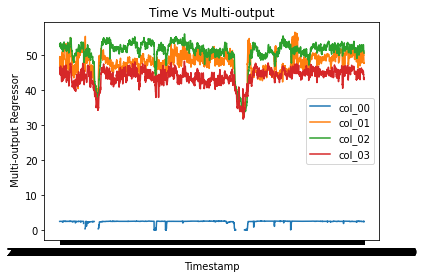

In [ ]:
plt.plot(train['timestamp'], train['col_00'], label = "col_00")

# plotting the line 2 points 
plt.plot(train['timestamp'], train['col_01'], label = "col_01")
plt.plot(train['timestamp'], train['col_02'], label = "col_02")
plt.plot(train['timestamp'], train['col_03'], label = "col_03")
plt.xlabel('Timestamp')
# Set the y axis label of the current axis.
plt.ylabel(' Multi-output Regressor')
# Set a title of the current axes.
plt.title('Time Vs Multi-output')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

Imbalanced classes

In [10]:
train['status'].value_counts()

status1    12281
status3      899
Name: status, dtype: int64

Number of Unique values in each feature

In [11]:
train.nunique(axis =0)

timestamp    13180
col_00         530
col_01         681
col_02         664
col_03         509
col_04        1791
col_05       12217
col_06         403
col_07         267
col_08         353
col_09         259
col_10       13004
col_11       12627
col_12       12261
col_13       12114
col_14       11526
col_15           0
col_16       12052
col_17       11960
col_18       12012
col_19       11332
col_20       11653
col_21       12586
col_22       11737
col_23       11515
col_24       11969
col_25       12120
col_26       12774
col_27       13045
col_28       13022
col_29       12879
col_30        1175
col_31        1506
col_32       13114
col_33       13099
col_34       13106
col_35       12860
col_36       12851
col_37       11978
col_38         301
col_39         312
col_40         459
col_41         222
col_42         228
col_43         297
col_44         324
col_45         363
col_46         407
col_47         323
col_48        1090
col_49         490
col_50         757
col_51      

Feature-wise distribution provides min, max, mean, std, quartiles and count

In [12]:
train.describe()

,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_08,col_09,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
count,12547.000000,13153.000000,13177.000000,13177.000000,13177.000000,13177.000000,12888.000000,12853.000000,12868.000000,12899.000000,13177.000000,13177.000000,13177.000000,13177.000000,13177.000000,0.0,13177.000000,13175.000000,13175.000000,13178.000000,13178.000000,13178.000000,13176.000000,13178.000000,13178.000000,13178.000000,13178.000000,13178.000000,13178.000000,13176.000000,13164.000000,13178.000000,13175.000000,13178.000000,13178.000000,13178.000000,13178.000000,13178.000000,13174.000000,13174.000000,13174.000000,13174.000000,13174.000000,13174.000000,13174.000000,13174.000000,13174.000000,13174.000000,13174.000000,13174.000000,8540.000000,12238.000000
mean,2.371476,47.553350,50.806670,43.721105,589.227768,73.420198,13.492147,15.828899,15.182792,14.801948,41.416157,41.795962,29.077539,7.108902,378.811851,NaN,418.605857,422.850581,2.313192,594.394175,362.609048,800.173015,462.618290,928.086050,559.421271,653.226810,791.353091,502.514763,857.064500,578.159304,617.751123,867.656755,808.162769,487.948681,236.253179,429.336413,596.739991,60.572338,49.693485,36.744607,68.524094,35.378711,35.530505,43.799378,42.634088,42.995309,48.006848,44.326277,150.293139,57.010528,182.252939,203.392126
std,0.415394,3.327408,3.730022,2.435741,146.941135,17.338304,2.192931,2.260817,2.121527,2.132435,12.227269,13.180518,10.167814,6.926032,111.036049,NaN,123.668145,126.695588,0.750360,195.214139,99.860478,222.097408,151.287971,286.098527,178.905668,216.802665,242.801009,167.633095,310.076642,221.802624,193.036026,280.636892,258.601410,147.676053,88.230812,140.305596,287.374272,37.604120,11.050471,16.230087,21.310851,8.101352,10.844165,11.355818,11.453644,12.777097,15.380907,10.160749,82.055343,20.314003,65.084686,111.955387
min,0.001968,32.204860,33.159720,31.640620,2.798032,0.000000,0.014468,0.028935,0.028935,0.007234,0.000000,0.000000,0.000000,0.000000,33.396057,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,104.113500,0.000000,0.000000,0.000000,0.000000,45.561240,0.000000,18.900840,2.546296,11.111110,36.979160,1.756815,8.374819,58.247310,0.000000,23.672827,0.000000,24.479166,19.270832,23.697916,20.833330,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.438831,46.267360,50.347220,42.795140,626.388900,69.939150,13.346350,15.907120,15.183740,15.053530,40.730190,38.684440,28.625320,1.547304,418.286000,NaN,459.755100,454.384750,2.449682,663.008725,398.116125,875.740625,479.939800,951.257500,601.186050,695.341575,795.780875,449.063375,785.873400,520.633925,629.629600,841.666600,765.569100,490.632075,172.281325,353.452325,291.721050,28.461658,45.572910,32.552080,57.812500,32.552080,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.622690,47.743060,167.824100,179.181125
50%,2.456539,48.046880,51.649300,44.227428,632.638900,75.684070,13.642940,16.167530,15.494790,15.082470,44.376040,45.379850,32.531670,2.996827,420.117400,NaN,462.873500,462.008100,2.533353,665.691200,399.378300,879.721650,531.896200,982.288550,625.959950,740.532600,868.861600,494.933500,974.419250,565.056150,670.833300,920.312400,880.060100,512.577900,226.950100,476.364550,711.646800,63.624910,49.479160,35.416660,66.145830,34.895832,35.156250,42.968750,40.509260,40.219910,44.849537,42.534720,137.152800,52.662037,193.865700,197.916700
75%,2.499826,49.479160,52.777770,45.225693,637.615723,80.862140,14.539930,16.427950,15.697340,15.118630,47.449130,49.640030,34.947990,12.875390,421.019300,NaN,464.296300,466.951900,2.587946,667.129150,400.080625,882.101250,534.256025,1090.869000,628.656975,750.453150,920.824800,536.343375,1046.022000,745.714625,698.61110

**Data info:**
- All the features are mostly float64 (continuous)
- timestamp is string type
- status is categorical (Two classes)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13180 entries, 12278 to 929
Data columns (total 54 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  13180 non-null  object 
 1   col_00     12547 non-null  float64
 2   col_01     13153 non-null  float64
 3   col_02     13177 non-null  float64
 4   col_03     13177 non-null  float64
 5   col_04     13177 non-null  float64
 6   col_05     13177 non-null  float64
 7   col_06     12888 non-null  float64
 8   col_07     12853 non-null  float64
 9   col_08     12868 non-null  float64
 10  col_09     12899 non-null  float64
 11  col_10     13177 non-null  float64
 12  col_11     13177 non-null  float64
 13  col_12     13177 non-null  float64
 14  col_13     13177 non-null  float64
 15  col_14     13177 non-null  float64
 16  col_15     0 non-null      float64
 17  col_16     13177 non-null  float64
 18  col_17     13175 non-null  float64
 19  col_18     13175 non-null  float64
 20  col_

In [14]:
train.shape

(13180, 54)

Number of Missing values in each features

In [15]:
train.isna().sum()

timestamp        0
col_00         633
col_01          27
col_02           3
col_03           3
col_04           3
col_05           3
col_06         292
col_07         327
col_08         312
col_09         281
col_10           3
col_11           3
col_12           3
col_13           3
col_14           3
col_15       13180
col_16           3
col_17           5
col_18           5
col_19           2
col_20           2
col_21           2
col_22           4
col_23           2
col_24           2
col_25           2
col_26           2
col_27           2
col_28           2
col_29           4
col_30          16
col_31           2
col_32           5
col_33           2
col_34           2
col_35           2
col_36           2
col_37           2
col_38           6
col_39           6
col_40           6
col_41           6
col_42           6
col_43           6
col_44           6
col_45           6
col_46           6
col_47           6
col_48           6
col_49           6
col_50        4640
col_51      

#### Data Preprocessing

**Step1:**Drop col_15 as it is entirely null

In [16]:
train.drop(['col_15'], axis = 1, inplace =True)

In [17]:
train.head()

,timestamp,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_08,col_09,col_10,col_11,col_12,col_13,col_14,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,status
12278,2018-04-01 00:20:00,2.445718,49.08854,53.03819,46.310760,633.4491,76.95741,13.34635,16.16753,15.76968,15.11863,42.12564,51.53938,36.60661,1.784164,419.6276,463.2421,464.6749,2.563032,665.8941,399.7498,881.9748,498.5272,977.5908,630.2238,739.1276,850.9550,455.6373,788.3645,701.0446,664.8148,761.4583,664.2639,460.5655,166.7023,324.9857,201.4553,82.36915,46.87500,34.89583,71.61458,32.81250,32.291660,40.36458,41.66667,53.53009,43.69213,40.509260,221.3542,76.67824,236.9792,198.7847,status1
8372,2018-04-01 00:53:00,2.459491,49.30555,53.12500,46.050346,622.1064,77.45465,13.41146,16.21094,15.69734,15.08247,42.33437,51.17097,37.03177,1.938014,420.3519,462.7575,454.0148,2.443620,668.5105,398.9754,879.8754,500.4963,978.5619,629.0044,734.6092,850.0377,452.3379,779.9328,707.1124,677.7778,773.9583,717.5763,454.2669,167.9275,333.9023,197.9963,86.42762,53.64583,33.07291,70.83333,32.81250,32.552080,39.32291,40.79861,41.95602,45.13889,39.062500,192.9977,68.57639,228.5880,209.7801,status1
771,2018-04-01 01:11:00,2.460474,48.26389,53.16840,45.963539,633.9120,71.67192,13.65017,16.07350,15.65393,15.11863,39.92451,54.63234,36.56225,2.041516,420.4692,463.3123,468.8456,2.613089,666.2465,400.3882,879.6164,500.8356,978.8798,627.8996,739.9337,847.2256,431.5300,782.2994,704.3047,653.7037,703.1250,672.9811,443.5051,173.8443,342.1648,209.9130,91.06766,49.21875,31.25000,61.71875,33.85416,32.552082,38.02083,42.53472,48.32176,40.79861,39.062500,165.5093,74.07407,219.9074,210.9375,status1
2213,2018-04-01 01:31:00,2.466377,47.26563,53.03819,45.963539,634.1435,76.95788,13.59230,16.16753,15.45139,15.11863,38.04627,51.71697,39.29346,1.909490,420.4633,463.6290,460.4578,2.516070,665.9415,399.8187,881.2762,500.8628,978.8847,628.8224,741.9232,850.1055,458.8968,774.5200,681.5573,660.6481,755.2083,690.2231,475.6694,170.5929,333.1820,203.2823,113.24720,46.87500,33.07291,62.23958,31.77083,32.552080,38.80208,41.66667,46.29630,46.00694,39.641205,184.0278,69.73380,234.6644,192.9977,status1
9011,2018-04-01 01:42:00,2.465394,48.43750,53.12500,45.963539,634.7222,73.23296,13.59230,16.16030,15.61777,15.08247,39.50881,51.02778,37.19251,2.024022,420.7476,465.8351,468.3325,2.596330,668.3465,400.5117,883.1757,501.2707,983.9818,630.1022,740.7512,850.9871,489.1272,763.6697,715.5057,620.3704,713.0208,728.0577,448.5822,170.9337,325.3874,203.4722,106.03250,47.91666,33.85416,75.26041,31.77083,33.854160,40.62500,47.74306,49.18982,44.56018,39.641200,203.9931,69.73380,241.3194,196.4699,status1


In [18]:
train.tail()

,timestamp,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_08,col_09,col_10,col_11,col_12,col_13,col_14,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,status
7962,2018-08-31 22:32:00,2.406366,47.569440,50.607640,42.968750,635.185200,72.56624,15.11863,16.75347,15.69734,15.08247,41.92376,44.70903,33.48946,13.22342,421.2293,463.5535,462.8673,2.549643,676.4089,406.5284,897.1830,542.8336,1109.755,610.9133,701.1017,802.0426,238.1385,786.4402,502.6483,652.3148,914.5833,897.5427,474.8704,252.2751,524.2157,781.9071,0.0,44.53125,40.36458,93.75000,27.604166,30.468748,46.61458,64.23611,36.45833,41.66667,36.168980,243.0556,79.28241,NaN,189.5255,status1
11101,2018-08-31 22:57:00,2.404398,47.786457,50.607640,42.925350,638.425903,71.96146,15.15480,16.65220,15.49479,15.07523,41.22496,50.20221,37.39506,13.31231,421.1351,460.8445,456.2864,2.480398,674.2866,405.1282,891.1063,541.6964,1107.992,606.1431,697.7043,802.4302,199.9451,800.3796,509.4537,704.1666,921.8749,907.4521,477.3006,258.7791,557.8571,813.0450,0.0,42.96875,28.64583,98.69791,28.645830,29.166670,45.31250,69.73380,44.56018,53.24074,38.773148,233.2176,160.30090,NaN,236.4005,status1
10954,2018-08-31 23:01:00,2.400463,47.786457,50.564240,42.968750,633.449097,67.54071,15.23438,16.70284,15.73351,15.08247,43.03067,51.76569,37.28714,13.37157,419.3033,463.7610,474.1706,2.667689,674.0717,406.1680,891.7249,543.6187,1107.346,611.3492,698.7509,795.1298,235.4872,786.6971,489.7051,668.5185,890.6249,900.4467,469.5951,239.4692,511.1585,779.7717,0.0,45.57291,27.86458,92.96875,29.687500,29.947920,44.27083,77.83565,43.98148,55.55556,39.062500,236.4005,170.71760,NaN,242.7662,status1
5194,2018-08-31 23:40:00,2.404398,47.699650,50.564236,43.142361,629.670200,67.65578,14.96672,16.70284,15.76968,15.11863,38.35430,49.57625,34.72324,13.13500,419.4510,460.9641,460.7762,2.529140,673.0524,405.4648,892.6406,539.5195,1103.166,605.1906,699.4781,803.9229,556.9876,799.9782,505.2794,673.6111,938.5416,940.6673,475.4381,216.6394,495.9624,792.7513,0.0,41.92708,28.38542,68.75000,29.166670,28.645832,38.02083,64.23611,39.06250,46.58565,39.062500,295.1389,97.22222,NaN,199.9421,status1
929,2018-08-31 23:47:00,2.400463,47.699650,50.520830,43.142361,616.319500,64.95082,15.11863,16.65220,15.76968,15.05353,45.84744,50.50845,37.71803,13.22898,420.6334,467.8338,473.7973,2.666879,678.6484,407.8755,897.0770,545.5964,1110.503,612.2659,697.9404,796.8893,623.8124,784.7404,492.8418,656.9445,886.4583,902.6426,497.1160,251.5252,533.2466,775.9019,0.0,44.27083,27.86458,61.45833,29.947916,29.166670,35.67708,72.33796,46.87500,46.58565,40.509258,269.0972,112.55790,NaN,202.2569,status1


Insight: Data: 1-04-2018 to 31-08-2018

**Step2:**
- Ground truth **col_00, col_01, col_02, col_03** has null values.
- As there is class imbalance, dropping these null rows would result in severe class imbalance. So we are imputing GT by interpolation method. 

In [19]:
train['status'].value_counts()

status1    12281
status3      899
Name: status, dtype: int64

In [20]:
train.shape

(13180, 53)

**step3:**Convert categorical variable status to numerical using one hot encoder

In [22]:
label_encoder = LabelEncoder()
train['status'] = label_encoder.fit_transform(train['status'])

**Step4:**Dropping timestamp column

In [23]:
train.drop('timestamp', axis=1, inplace=True)

**step5:**Treating missing values by the method of interpolation

In [24]:
train_interpolate = train

In [25]:
train_interpolate.isna().sum()

col_00     633
col_01      27
col_02       3
col_03       3
col_04       3
col_05       3
col_06     292
col_07     327
col_08     312
col_09     281
col_10       3
col_11       3
col_12       3
col_13       3
col_14       3
col_16       3
col_17       5
col_18       5
col_19       2
col_20       2
col_21       2
col_22       4
col_23       2
col_24       2
col_25       2
col_26       2
col_27       2
col_28       2
col_29       4
col_30      16
col_31       2
col_32       5
col_33       2
col_34       2
col_35       2
col_36       2
col_37       2
col_38       6
col_39       6
col_40       6
col_41       6
col_42       6
col_43       6
col_44       6
col_45       6
col_46       6
col_47       6
col_48       6
col_49       6
col_50    4640
col_51     942
status       0
dtype: int64

Interpolate by Backward fill (so the first null values in the row isn't empty)

In [34]:
cols = ['col_00','col_01','col_02', 'col_03','col_04','col_05','col_06', 'col_07','col_08' ,'col_09', 'col_10','col_11','col_12','col_13','col_14', 'col_16','col_17', 'col_18', 'col_19','col_20','col_21','col_22','col_23','col_24','col_25','col_26','col_27','col_28','col_29', 'col_30', 'col_31', 'col_32', 'col_33','col_34', 'col_35', 'col_36','col_37', 'col_38', 'col_39', 'col_40', 'col_41' , 'col_42', 'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48', 'col_49', 'col_50', 'col_51']
train_interpolate[cols] = train_interpolate[cols].interpolate().fillna(method='bfill')

Missing value Treated

In [35]:
train_interpolate.isna().sum()

col_00    0
col_01    0
col_02    0
col_03    0
col_04    0
col_05    0
col_06    0
col_07    0
col_08    0
col_09    0
col_10    0
col_11    0
col_12    0
col_13    0
col_14    0
col_16    0
col_17    0
col_18    0
col_19    0
col_20    0
col_21    0
col_22    0
col_23    0
col_24    0
col_25    0
col_26    0
col_27    0
col_28    0
col_29    0
col_30    0
col_31    0
col_32    0
col_33    0
col_34    0
col_35    0
col_36    0
col_37    0
col_38    0
col_39    0
col_40    0
col_41    0
col_42    0
col_43    0
col_44    0
col_45    0
col_46    0
col_47    0
col_48    0
col_49    0
col_50    0
col_51    0
status    0
dtype: int64

In [36]:
train_interpolate.shape

(13180, 52)

**Step6:** Outlier treatment

- columns with value 1000 (outliers) are treated by replacing with 95th and 5th Quantile values in 

In [37]:
num_col = train_interpolate.select_dtypes(include=['float64']).columns.tolist()
train_interpolate[num_col] = train_interpolate[num_col].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))

In [38]:
train_interpolate.head()

,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_08,col_09,col_10,col_11,col_12,col_13,col_14,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,status
12278,2.445718,49.08854,53.03819,46.310760,633.4491,76.95741,13.34635,16.16753,15.76968,15.11863,42.12564,51.539380,36.606610,1.784164,419.6276,463.2421,464.6749,2.563032,665.8941,399.7498,881.9748,498.5272,977.5908,630.2238,739.1276,850.9550,455.6373,788.3645,701.0446,664.8148,761.4583,664.2639,460.5655,166.7023,324.9857,201.4553,82.36915,46.87500,34.89583,71.61458,32.81250,32.291660,40.36458,41.66667,53.53009,43.69213,40.509260,221.3542,76.67824,236.9792,198.7847,0
8372,2.459491,49.30555,53.12500,46.050346,622.1064,77.45465,13.41146,16.21094,15.69734,15.08247,42.33437,51.170970,37.031770,1.938014,420.3519,462.7575,454.0148,2.443620,668.5105,398.9754,879.8754,500.4963,978.5619,629.0044,734.6092,850.0377,452.3379,779.9328,707.1124,677.7778,773.9583,717.5763,454.2669,167.9275,333.9023,197.9963,86.42762,53.64583,33.07291,70.83333,32.81250,32.552080,39.32291,40.79861,41.95602,45.13889,39.062500,192.9977,68.57639,228.5880,209.7801,0
771,2.460474,48.26389,53.16840,45.963539,633.9120,71.67192,13.65017,16.07350,15.65393,15.11863,39.92451,54.163438,36.562250,2.041516,420.4692,463.3123,468.8456,2.613089,666.2465,400.3882,879.6164,500.8356,978.8798,627.8996,739.9337,847.2256,431.5300,782.2994,704.3047,653.7037,703.1250,672.9811,443.5051,173.8443,342.1648,209.9130,91.06766,49.21875,31.25000,61.71875,33.85416,32.552082,38.02083,42.53472,48.32176,40.79861,39.062500,165.5093,74.07407,219.9074,210.9375,0
2213,2.466377,47.26563,53.03819,45.963539,634.1435,76.95788,13.59230,16.16753,15.45139,15.11863,38.04627,51.716970,37.974952,1.909490,420.4633,463.6290,460.4578,2.516070,665.9415,399.8187,881.2762,500.8628,978.8847,628.8224,741.9232,850.1055,458.8968,774.5200,681.5573,660.6481,755.2083,690.2231,475.6694,170.5929,333.1820,203.2823,113.24720,46.87500,33.07291,62.23958,31.77083,32.552080,38.80208,41.66667,46.29630,46.00694,39.641205,184.0278,69.73380,234.6644,192.9977,0
9011,2.465394,48.43750,53.12500,45.963539,634.7222,73.23296,13.59230,16.16030,15.61777,15.08247,39.50881,51.027780,37.192510,2.024022,420.7476,465.8351,468.3325,2.596330,668.3465,400.5117,883.1757,501.2707,983.9818,630.1022,740.7512,850.9871,489.1272,763.6697,715.5057,620.3704,713.0208,728.0577,448.5822,170.9337,325.3874,203.4722,106.03250,47.91666,33.85416,75.26041,31.77083,33.854160,40.62500,47.74306,49.18982,44.56018,39.641200,203.9931,69.73380,241.3194,196.4699,0


In [39]:
train_interpolate.shape

(13180, 52)

**Step7:** Split data into independent and dependent features

In [45]:
train_x = train_interpolate.iloc[:, 4:51]
train_y = train_interpolate.iloc[:, 0:4]
#train_ystatus = train.iloc[:, 52:]

In [42]:
print(train_x.shape, train_y.shape)

(13180, 48) (13180, 4)


**step8:** 
- Pearson's correlation for continuous values

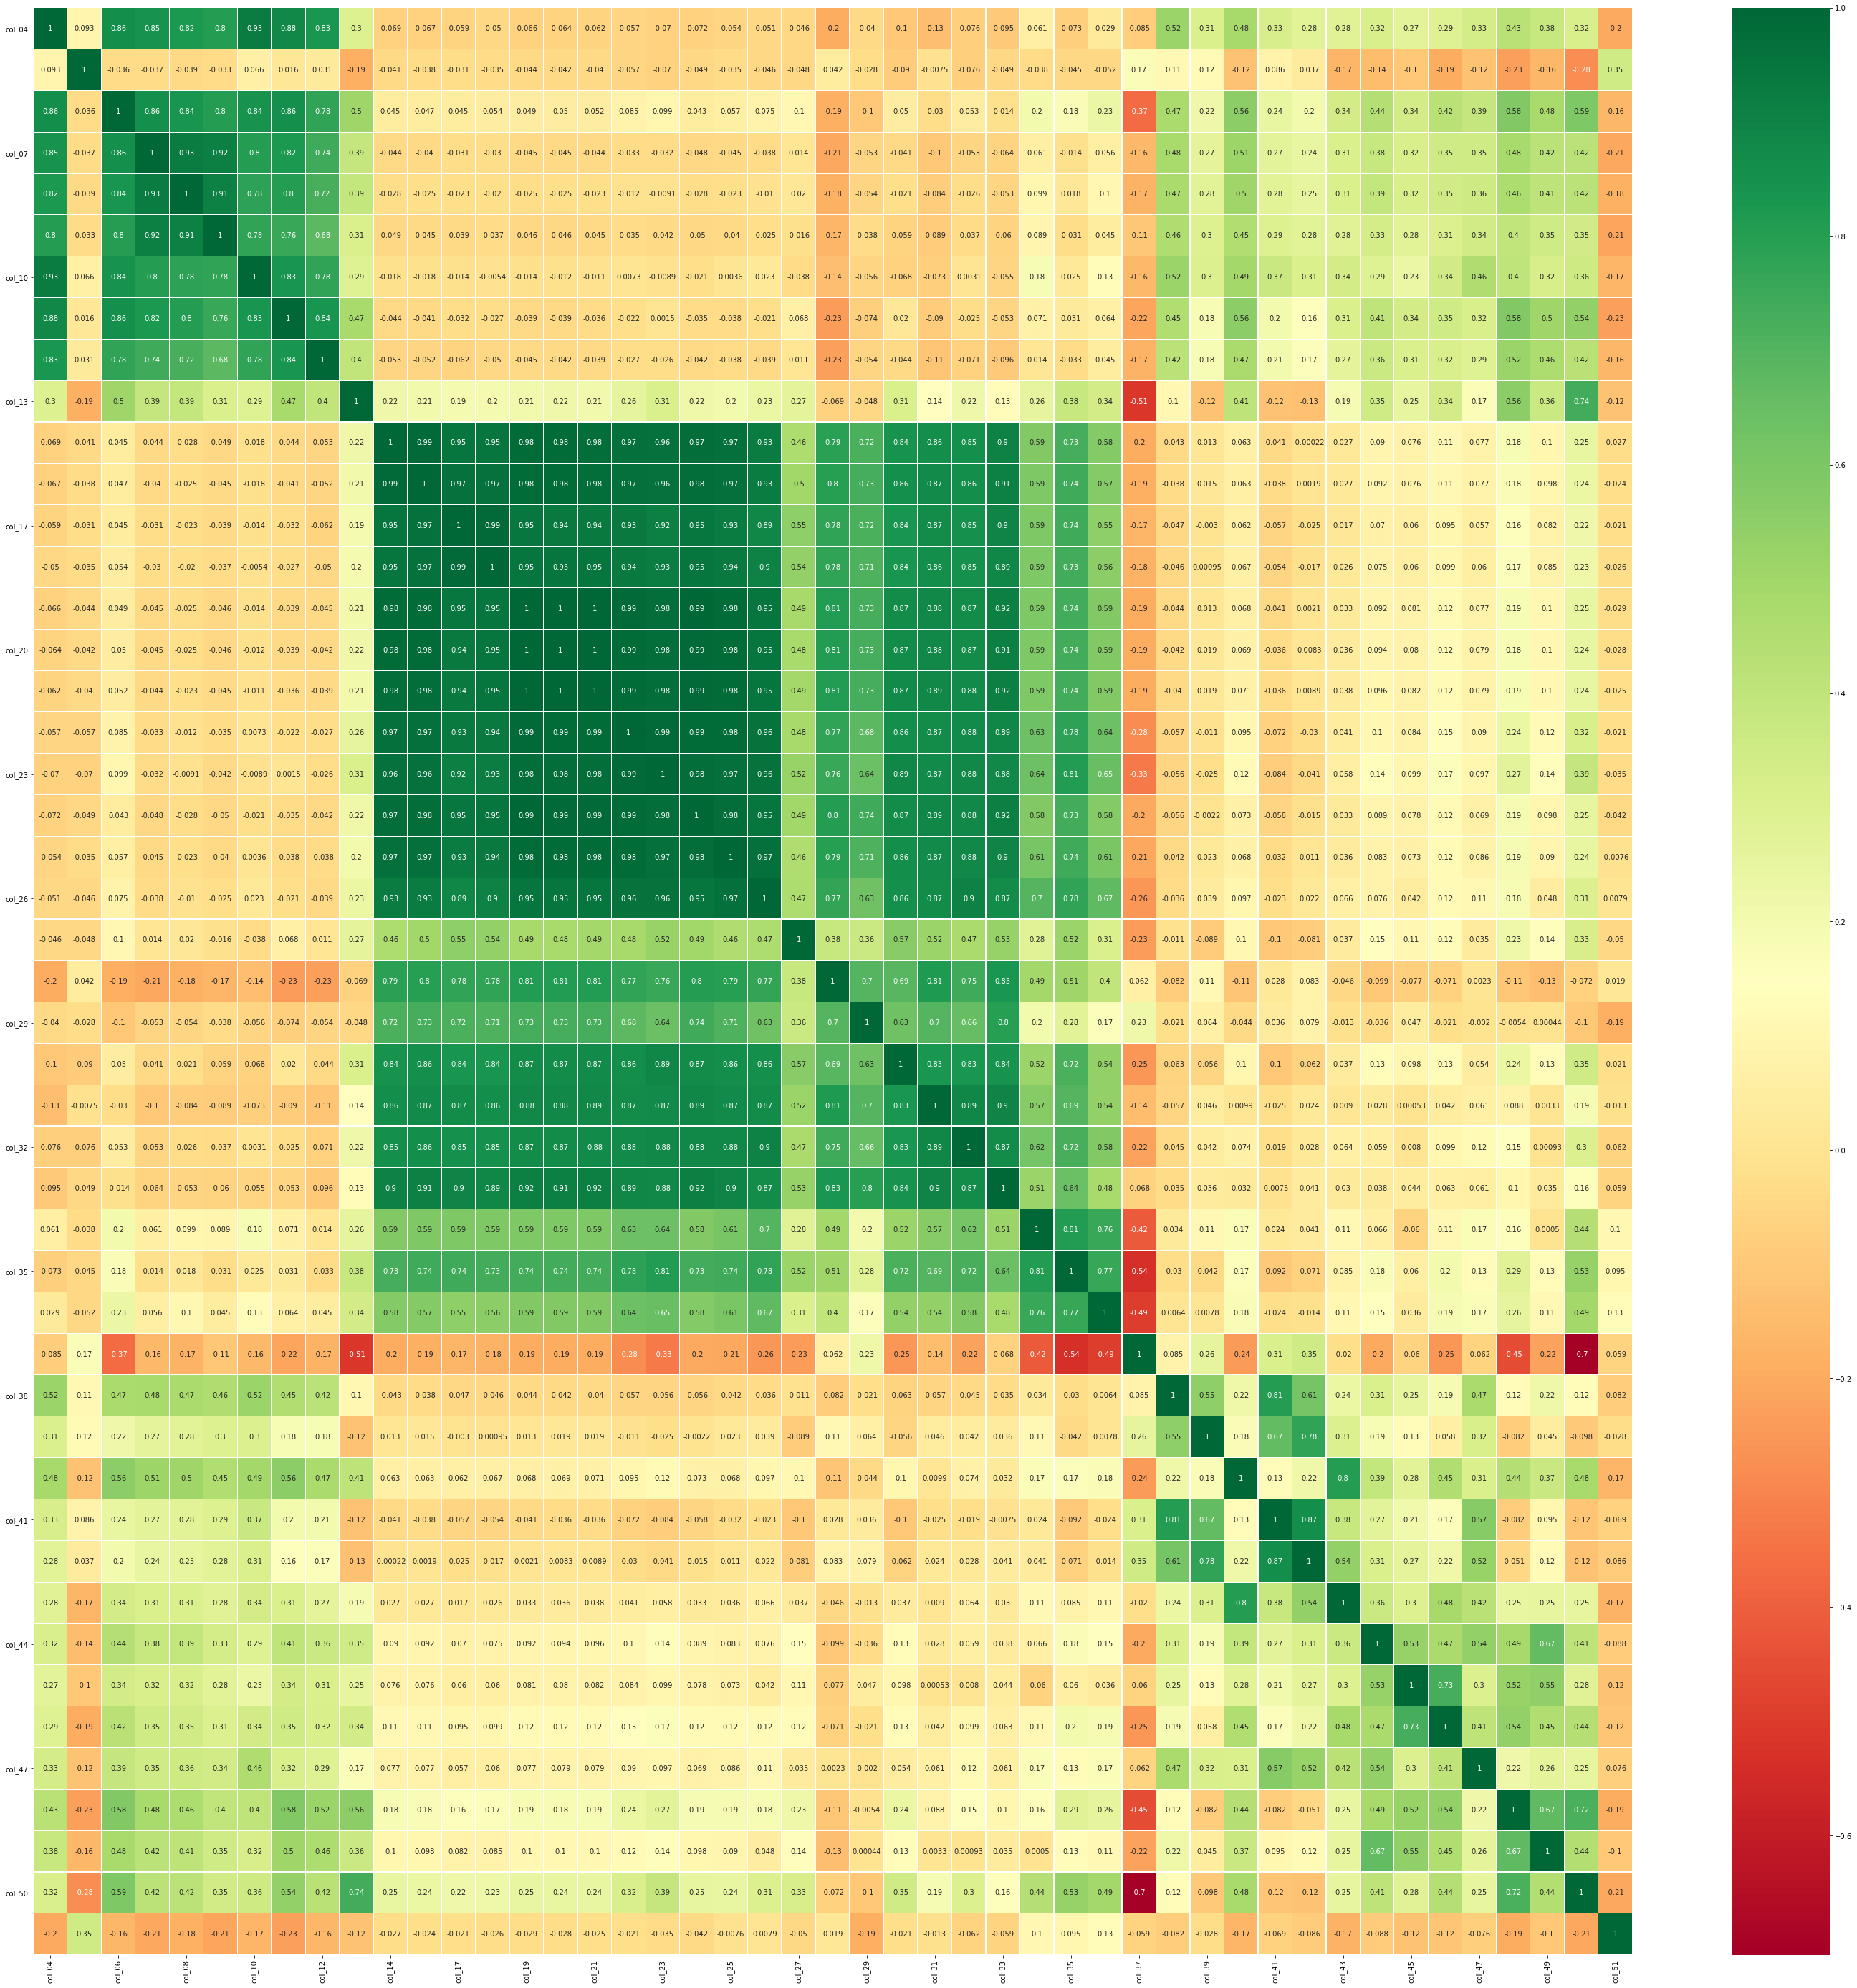

In [48]:
sns.heatmap(train_x.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(50,50)
plt.show()

In [49]:
corr = train_x.corr()
corr.head()

,col_04,col_05,col_06,col_07,col_08,col_09,col_10,col_11,col_12,col_13,col_14,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
col_04,1.000000,0.092514,0.862749,0.846467,0.821669,0.804010,0.928761,0.883955,0.829245,0.296600,-0.069245,-0.067206,-0.059254,-0.050193,-0.065623,-0.063828,-0.061537,-0.057286,-0.070279,-0.071882,-0.053683,-0.051391,-0.046396,-0.197677,-0.040320,-0.102275,-0.132752,-0.076073,-0.094672,0.060692,-0.073290,0.029026,-0.084612,0.518664,0.310007,0.481454,0.327566,0.279899,0.284361,0.318420,0.270153,0.288799,0.332422,0.425350,0.377097,0.317557,-0.202887
col_05,0.092514,1.000000,-0.035660,-0.036579,-0.039278,-0.033035,0.065942,0.016160,0.031170,-0.191014,-0.041349,-0.037583,-0.030779,-0.035273,-0.044415,-0.042431,-0.040388,-0.056939,-0.069836,-0.048940,-0.034885,-0.046202,-0.048455,0.041745,-0.028230,-0.089651,-0.007496,-0.076093,-0.049488,-0.038159,-0.045371,-0.051724,0.172483,0.111023,0.118141,-0.123690,0.086321,0.036646,-0.171614,-0.143539,-0.102561,-0.193885,-0.122711,-0.225417,-0.163970,-0.277436,0.353031
col_06,0.862749,-0.035660,1.000000,0.856699,0.838622,0.804890,0.844164,0.859059,0.779041,0.500781,0.045037,0.046648,0.044549,0.053534,0.048821,0.049668,0.052308,0.084791,0.099262,0.042904,0.056907,0.075327,0.101994,-0.185474,-0.101713,0.050451,-0.029944,0.052510,-0.013839,0.201712,0.180504,0.231690,-0.368955,0.470970,0.220202,0.559535,0.242039,0.202969,0.338648,0.438239,0.339637,0.423478,0.385236,0.583285,0.477527,0.588351,-0.159075
col_07,0.846467,-0.036579,0.856699,1.000000,0.930628,0.918377,0.800945,0.822469,0.741570,0.385124,-0.043552,-0.040454,-0.031184,-0.029532,-0.044960,-0.044973,-0.043649,-0.032882,-0.032018,-0.048492,-0.044844,-0.038332,0.013928,-0.210318,-0.053112,-0.040687,-0.103996,-0.053141,-0.063714,0.060836,-0.013745,0.055593,-0.156697,0.475444,0.266780,0.509507,0.271285,0.243412,0.311510,0.378669,0.319439,0.351241,0.352288,0.478030,0.416910,0.419759,-0.211526
col_08,0.821669,-0.039278,0.838622,0.930628,1.000000,0.907657,0.784114,0.803992,0.723369,0.391890,-0.028228,-0.024924,-0.022585,-0.019650,-0.025340,-0.024654,-0.022794,-0.011828,-0.009087,-0.027571,-0.022774,-0.010051,0.020207,-0.184662,-0.053934,-0.020988,-0.084194,-0.026434,-0.053297,0.098927,0.017887,0.101390,-0.172460,0.472174,0.277507,0.503586,0.278020,0.248520,0.310063,0.393004,0.316744,0.346393,0.358090,0.464543,0.410931,0.420253,-0.184120


columns with >90% correation

In [50]:
columns = np.full((corr.shape[0],), True, dtype=bool)

#pcc_cols = ['c1', 'c2', 'Co-effs']
#pcc_lst =[]

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        #pcc_lst.append([i, j, corr.iloc[i,j]])
        #pcc_df1 = pd.DataFrame(pcc_lst, columns = pcc_cols)
        if corr.iloc[i,j] >= 0.9 or corr.iloc[i,j] <= -0.9:
            if columns[j]:
                columns[j] = False

In [51]:
columns

array([ True,  True,  True,  True, False, False, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [52]:
selected_columns = train_x.columns[columns]
selected_columns.shape

(31,)

In [53]:
selected_columns

Index(['col_04', 'col_05', 'col_06', 'col_07', 'col_11', 'col_12', 'col_13',
       'col_14', 'col_27', 'col_28', 'col_29', 'col_30', 'col_31', 'col_34',
       'col_35', 'col_36', 'col_37', 'col_38', 'col_39', 'col_40', 'col_41',
       'col_42', 'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48',
       'col_49', 'col_50', 'col_51'],
      dtype='object')

selection of columns with <90% correlation

In [54]:
X = train_x[selected_columns]
X.shape

(13180, 31)

**Step10:**
- Data Distribution using histogram

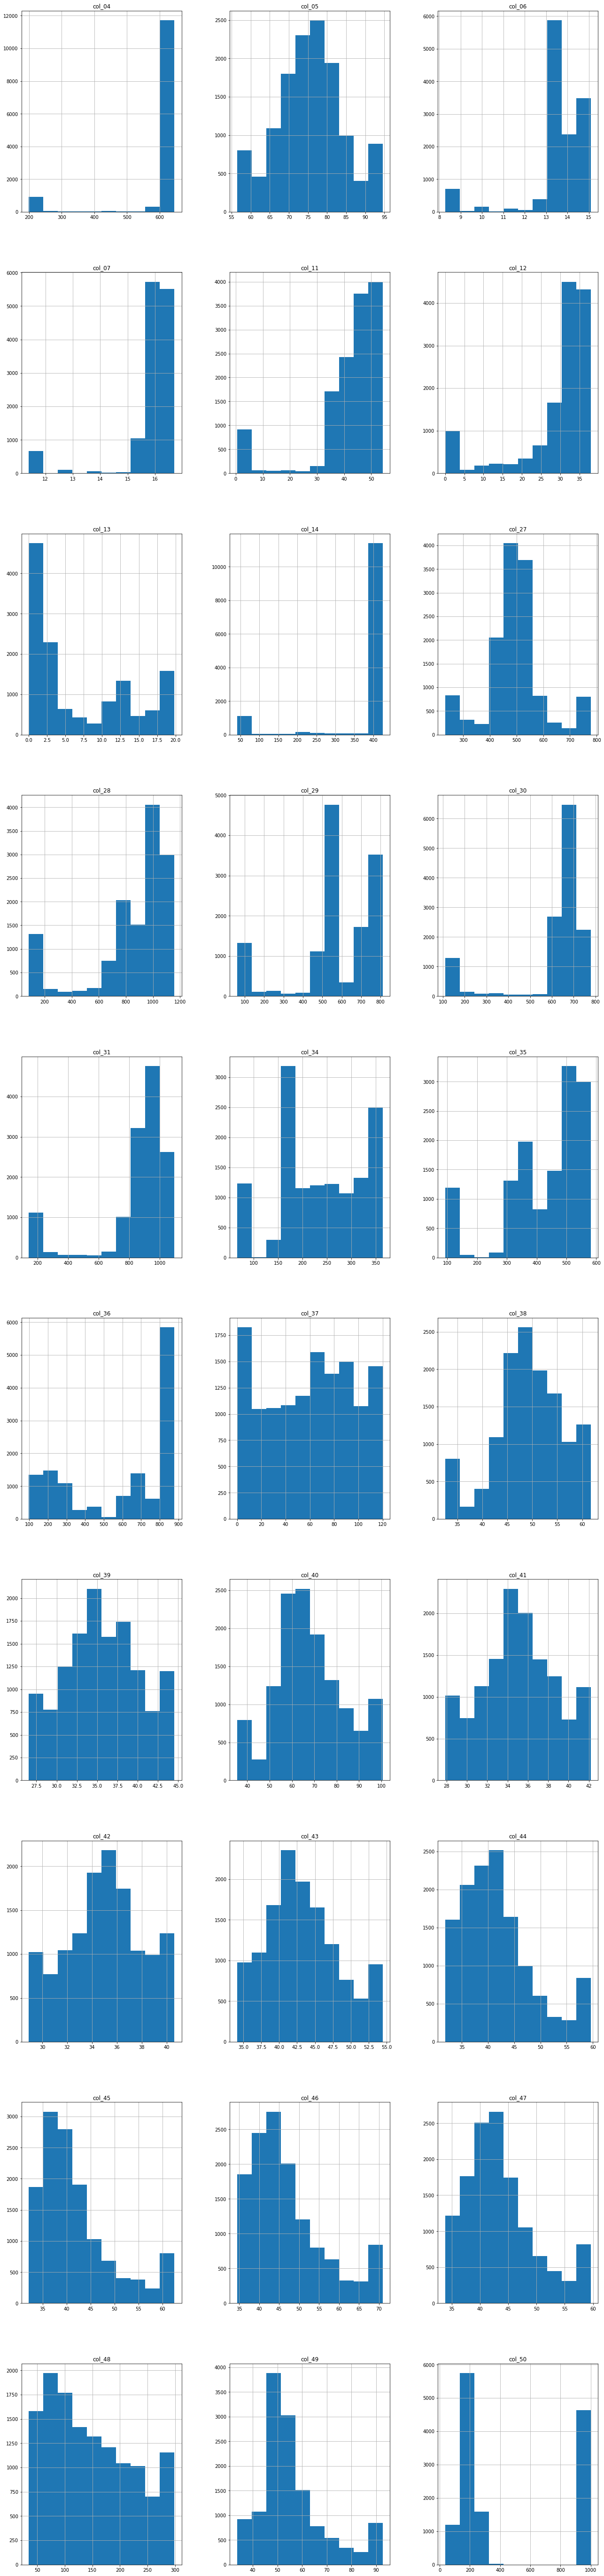

In [55]:
fig, axes = plt.subplots(len(X.columns)//3, 3, figsize=(22, 100))

i = 0
for triaxis in axes:
    for axis in triaxis:
        train.hist(column = X.columns[i], ax=axis)
        #sns.kdeplot(column = train_df.columns[i], ax=axis)
        i = i+1

Each feature has different range of values (aka distribution) hence standardisation of features before passing on to the model is mandatory

Note on dataframes:
<br>X df is with status column included 
<br>train_X df is with out status column for training the regressor

In [56]:
print(X.shape, train_y.shape)

(13180, 31) (13180, 4)


In [57]:
X.head()

,col_04,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
12278,633.4491,76.95741,13.34635,16.16753,51.539380,36.606610,1.784164,419.6276,455.6373,788.3645,701.0446,664.8148,761.4583,166.7023,324.9857,201.4553,82.36915,46.87500,34.89583,71.61458,32.81250,32.291660,40.36458,41.66667,53.53009,43.69213,40.509260,221.3542,76.67824,236.9792,198.7847
8372,622.1064,77.45465,13.41146,16.21094,51.170970,37.031770,1.938014,420.3519,452.3379,779.9328,707.1124,677.7778,773.9583,167.9275,333.9023,197.9963,86.42762,53.64583,33.07291,70.83333,32.81250,32.552080,39.32291,40.79861,41.95602,45.13889,39.062500,192.9977,68.57639,228.5880,209.7801
771,633.9120,71.67192,13.65017,16.07350,54.163438,36.562250,2.041516,420.4692,431.5300,782.2994,704.3047,653.7037,703.1250,173.8443,342.1648,209.9130,91.06766,49.21875,31.25000,61.71875,33.85416,32.552082,38.02083,42.53472,48.32176,40.79861,39.062500,165.5093,74.07407,219.9074,210.9375
2213,634.1435,76.95788,13.59230,16.16753,51.716970,37.974952,1.909490,420.4633,458.8968,774.5200,681.5573,660.6481,755.2083,170.5929,333.1820,203.2823,113.24720,46.87500,33.07291,62.23958,31.77083,32.552080,38.80208,41.66667,46.29630,46.00694,39.641205,184.0278,69.73380,234.6644,192.9977
9011,634.7222,73.23296,13.59230,16.16030,51.027780,37.192510,2.024022,420.7476,489.1272,763.6697,715.5057,620.3704,713.0208,170.9337,325.3874,203.4722,106.03250,47.91666,33.85416,75.26041,31.77083,33.854160,40.62500,47.74306,49.18982,44.56018,39.641200,203.9931,69.73380,241.3194,196.4699


In [58]:
train_X = X.iloc[:, 0:32]

In [59]:
train_X.head()

,col_04,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
12278,633.4491,76.95741,13.34635,16.16753,51.539380,36.606610,1.784164,419.6276,455.6373,788.3645,701.0446,664.8148,761.4583,166.7023,324.9857,201.4553,82.36915,46.87500,34.89583,71.61458,32.81250,32.291660,40.36458,41.66667,53.53009,43.69213,40.509260,221.3542,76.67824,236.9792,198.7847
8372,622.1064,77.45465,13.41146,16.21094,51.170970,37.031770,1.938014,420.3519,452.3379,779.9328,707.1124,677.7778,773.9583,167.9275,333.9023,197.9963,86.42762,53.64583,33.07291,70.83333,32.81250,32.552080,39.32291,40.79861,41.95602,45.13889,39.062500,192.9977,68.57639,228.5880,209.7801
771,633.9120,71.67192,13.65017,16.07350,54.163438,36.562250,2.041516,420.4692,431.5300,782.2994,704.3047,653.7037,703.1250,173.8443,342.1648,209.9130,91.06766,49.21875,31.25000,61.71875,33.85416,32.552082,38.02083,42.53472,48.32176,40.79861,39.062500,165.5093,74.07407,219.9074,210.9375
2213,634.1435,76.95788,13.59230,16.16753,51.716970,37.974952,1.909490,420.4633,458.8968,774.5200,681.5573,660.6481,755.2083,170.5929,333.1820,203.2823,113.24720,46.87500,33.07291,62.23958,31.77083,32.552080,38.80208,41.66667,46.29630,46.00694,39.641205,184.0278,69.73380,234.6644,192.9977
9011,634.7222,73.23296,13.59230,16.16030,51.027780,37.192510,2.024022,420.7476,489.1272,763.6697,715.5057,620.3704,713.0208,170.9337,325.3874,203.4722,106.03250,47.91666,33.85416,75.26041,31.77083,33.854160,40.62500,47.74306,49.18982,44.56018,39.641200,203.9931,69.73380,241.3194,196.4699


In [61]:
train_X.columns

Index(['col_04', 'col_05', 'col_06', 'col_07', 'col_11', 'col_12', 'col_13',
       'col_14', 'col_27', 'col_28', 'col_29', 'col_30', 'col_31', 'col_34',
       'col_35', 'col_36', 'col_37', 'col_38', 'col_39', 'col_40', 'col_41',
       'col_42', 'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48',
       'col_49', 'col_50', 'col_51'],
      dtype='object')

#### Splitting data into train and validation (80:20)

X_train, y_train - Training set
<br>X_test, y_test   - Validation set 

<br>Multi-output Regressor with MSE and r-squared metrics

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=1, shuffle= True)

## model fitting
model = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train, y_train)

## predict on test data - check metrics
Y_pred = model.predict(X_test)

print("MSE", mean_squared_error(y_test,Y_pred))
print("r2_score", r2_score(y_test,Y_pred))

MSE 1.742371662628745
r2_score 0.6763445899088085


In [63]:
df1 = pd.concat([train_y,train_X], axis =1).reset_index()

In [64]:
df1.head()

,index,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
0,12278,2.445718,49.08854,53.03819,46.310760,633.4491,76.95741,13.34635,16.16753,51.539380,36.606610,1.784164,419.6276,455.6373,788.3645,701.0446,664.8148,761.4583,166.7023,324.9857,201.4553,82.36915,46.87500,34.89583,71.61458,32.81250,32.291660,40.36458,41.66667,53.53009,43.69213,40.509260,221.3542,76.67824,236.9792,198.7847
1,8372,2.459491,49.30555,53.12500,46.050346,622.1064,77.45465,13.41146,16.21094,51.170970,37.031770,1.938014,420.3519,452.3379,779.9328,707.1124,677.7778,773.9583,167.9275,333.9023,197.9963,86.42762,53.64583,33.07291,70.83333,32.81250,32.552080,39.32291,40.79861,41.95602,45.13889,39.062500,192.9977,68.57639,228.5880,209.7801
2,771,2.460474,48.26389,53.16840,45.963539,633.9120,71.67192,13.65017,16.07350,54.163438,36.562250,2.041516,420.4692,431.5300,782.2994,704.3047,653.7037,703.1250,173.8443,342.1648,209.9130,91.06766,49.21875,31.25000,61.71875,33.85416,32.552082,38.02083,42.53472,48.32176,40.79861,39.062500,165.5093,74.07407,219.9074,210.9375
3,2213,2.466377,47.26563,53.03819,45.963539,634.1435,76.95788,13.59230,16.16753,51.716970,37.974952,1.909490,420.4633,458.8968,774.5200,681.5573,660.6481,755.2083,170.5929,333.1820,203.2823,113.24720,46.87500,33.07291,62.23958,31.77083,32.552080,38.80208,41.66667,46.29630,46.00694,39.641205,184.0278,69.73380,234.6644,192.9977
4,9011,2.465394,48.43750,53.12500,45.963539,634.7222,73.23296,13.59230,16.16030,51.027780,37.192510,2.024022,420.7476,489.1272,763.6697,715.5057,620.3704,713.0208,170.9337,325.3874,203.4722,106.03250,47.91666,33.85416,75.26041,31.77083,33.854160,40.62500,47.74306,49.18982,44.56018,39.641200,203.9931,69.73380,241.3194,196.4699


3 fold cross-validation

In [65]:
kf = KFold(n_splits = 3)
kf

KFold(n_splits=3, random_state=None, shuffle=False)

Linear regression and metrics for Cross validation dataset


*   Standardisation of only training data to avoid info leak using standardscalar
*   Linear regressor with Ridge regularizer 



In [66]:
id = df1.index
for train_index, test_index in kf.split(id):
  print("Train:", train_index, "Validation:",test_index)

  df_test = pd.DataFrame()
  df_train = pd.DataFrame()

  for i in train_index:
    df_tr = df1[(df1['index']== id[i])]
    df_train = pd.concat([df_train,df_tr])
    
  for j in test_index:
    df_ts = df1[(df1['index']== id[j])]
    df_test = pd.concat([df_test,df_ts], ignore_index = True)
    

  X_train = df_train.drop(['col_00', 'col_01', 'col_02', 'col_03'],1).reset_index()
  X_train = X_train.drop(['index'],1)
    
  Y_train = df_train[['col_00', 'col_01', 'col_02', 'col_03']].reset_index()
  Y_train = Y_train.drop(['index'],1)

  X_test = df_test.drop(['col_00', 'col_01', 'col_02', 'col_03'],1).reset_index()
  X_test = X_test.drop(['index'],1)

  Y_test = df_test[['col_00', 'col_01', 'col_02', 'col_03']].reset_index()
  Y_test = Y_test.drop(['index'],1)

  scaler = StandardScaler().fit(X_train.iloc[:, 1:34])  #StandardScaler();  MinMaxScaler()
  X_train_res_scaled = scaler.transform(X_train.iloc[:, 1:34])    #fit_transform(X_train1)
  X_test_scaled = scaler.transform(X_test.iloc[:, 1:34])
  
  X_train_num_scaled = pd.DataFrame(X_train_res_scaled, columns = X_train.iloc[:, 1:34].columns)
  X_test_num_scaled = pd.DataFrame(X_test_scaled, columns = X_test.iloc[:, 1:34].columns)
  ## model fitting
  model = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train_num_scaled, Y_train)

  ## predict on test data - check metrics
  Y_pred = model.predict(X_test_num_scaled)

  print("MSE", mean_squared_error(Y_test,Y_pred))
  print("r2_score", r2_score(Y_test,Y_pred))

Train: [ 4394  4395  4396 ... 13177 13178 13179] Validation: [   0    1    2 ... 4391 4392 4393]
MSE 1.7716502358165942
r2_score 0.6820168859514877
Train: [    0     1     2 ... 13177 13178 13179] Validation: [4394 4395 4396 ... 8784 8785 8786]
MSE 1.7460115179687334
r2_score 0.6937228597709592
Train: [   0    1    2 ... 8784 8785 8786] Validation: [ 8787  8788  8789 ... 13177 13178 13179]
MSE 1.7340748556997203
r2_score 0.7026124411924526


SVR model +Multioutput regressor wrapper

In [68]:
df1 = pd.concat([train_y,train_X], axis =1).reset_index()

id = df1.index
for train_index, test_index in kf.split(id):
  print("Train:", train_index, "Validation:",test_index)

  df_test = pd.DataFrame()
  df_train = pd.DataFrame()

  for i in train_index:
    df_tr = df1[(df1['index']== id[i])]
    df_train = pd.concat([df_train,df_tr])
    
  for j in test_index:
    df_ts = df1[(df1['index']== id[j])]
    df_test = pd.concat([df_test,df_ts], ignore_index = True)
    

  X_train = df_train.drop(['col_00', 'col_01', 'col_02', 'col_03'],1).reset_index()
  X_train = X_train.drop(['index'],1)
    
  Y_train = df_train[['col_00', 'col_01', 'col_02', 'col_03']].reset_index()
  Y_train = Y_train.drop(['index'],1)

  X_test = df_test.drop(['col_00', 'col_01', 'col_02', 'col_03'],1).reset_index()
  X_test = X_test.drop(['index'],1)

  Y_test = df_test[['col_00', 'col_01', 'col_02', 'col_03']].reset_index()
  Y_test = Y_test.drop(['index'],1)

  scaler = StandardScaler().fit(X_train.iloc[:, 1:34])  #StandardScaler();  MinMaxScaler()
  X_train_res_scaled = scaler.transform(X_train.iloc[:, 1:34])    #fit_transform(X_train1)
  X_test_scaled = scaler.transform(X_test.iloc[:, 1:34])
  
  X_train_num_scaled = pd.DataFrame(X_train_res_scaled, columns = X_train.iloc[:, 1:34].columns)
  X_test_num_scaled = pd.DataFrame(X_test_scaled, columns = X_test.iloc[:, 1:34].columns)
  ## model fitting
  model = LinearSVR()
  wrapper = MultiOutputRegressor(model).fit(X_train_num_scaled, Y_train)

  ## predict on test data - check metrics
  Y_pred = wrapper.predict(X_test_num_scaled)

  print("MSE", mean_squared_error(Y_test,Y_pred))
  print("r2_score", r2_score(Y_test,Y_pred))

Train: [ 4394  4395  4396 ... 13177 13178 13179] Validation: [   0    1    2 ... 4391 4392 4393]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE 1.841894085063047
r2_score 0.6670610035118973
Train: [    0     1     2 ... 13177 13178 13179] Validation: [4394 4395 4396 ... 8784 8785 8786]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE 1.8218098184102134
r2_score 0.6769369088951
Train: [   0    1    2 ... 8784 8785 8786] Validation: [ 8787  8788  8789 ... 13177 13178 13179]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE 1.7851773869485172
r2_score 0.6896696823434407


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Decision Tree + Multioutput regressor

In [69]:
df1 = pd.concat([train_y,train_X], axis =1).reset_index()

id = df1.index
for train_index, test_index in kf.split(id):
  print("Train:", train_index, "Validation:",test_index)

  df_test = pd.DataFrame()
  df_train = pd.DataFrame()

  for i in train_index:
    df_tr = df1[(df1['index']== id[i])]
    df_train = pd.concat([df_train,df_tr])
    
  for j in test_index:
    df_ts = df1[(df1['index']== id[j])]
    df_test = pd.concat([df_test,df_ts], ignore_index = True)
    

  X_train = df_train.drop(['col_00', 'col_01', 'col_02', 'col_03'],1).reset_index()
  X_train = X_train.drop(['index'],1)
    
  Y_train = df_train[['col_00', 'col_01', 'col_02', 'col_03']].reset_index()
  Y_train = Y_train.drop(['index'],1)

  X_test = df_test.drop(['col_00', 'col_01', 'col_02', 'col_03'],1).reset_index()
  X_test = X_test.drop(['index'],1)

  Y_test = df_test[['col_00', 'col_01', 'col_02', 'col_03']].reset_index()
  Y_test = Y_test.drop(['index'],1)

  scaler = StandardScaler().fit(X_train.iloc[:, 1:34])  #StandardScaler();  MinMaxScaler()
  X_train_res_scaled = scaler.transform(X_train.iloc[:, 1:34])    #fit_transform(X_train1)
  X_test_scaled = scaler.transform(X_test.iloc[:, 1:34])
  
  X_train_num_scaled = pd.DataFrame(X_train_res_scaled, columns = X_train.iloc[:, 1:34].columns)
  X_test_num_scaled = pd.DataFrame(X_test_scaled, columns = X_test.iloc[:, 1:34].columns)
  ## model fitting
  model = DecisionTreeRegressor().fit(X_train_num_scaled, Y_train)

  ## predict on test data - check metrics
  Y_pred = model.predict(X_test_num_scaled)

  print("MSE", mean_squared_error(Y_test,Y_pred))
  print("r2_score", r2_score(Y_test,Y_pred))

Train: [ 4394  4395  4396 ... 13177 13178 13179] Validation: [   0    1    2 ... 4391 4392 4393]
MSE 1.114021024435897
r2_score 0.7860077348754506
Train: [    0     1     2 ... 13177 13178 13179] Validation: [4394 4395 4396 ... 8784 8785 8786]
MSE 0.9913742546819336
r2_score 0.8077009249008318
Train: [   0    1    2 ... 8784 8785 8786] Validation: [ 8787  8788  8789 ... 13177 13178 13179]
MSE 1.0539212183364424
r2_score 0.8102325651794695


K-Nearest neighbours for multioutput regression

In [70]:
df1 = pd.concat([train_y,train_X], axis =1).reset_index()
id = df1.index
for train_index, test_index in kf.split(id):
  print("Train:", train_index, "Validation:",test_index)

  df_test = pd.DataFrame()
  df_train = pd.DataFrame()

  for i in train_index:
    df_tr = df1[(df1['index']== id[i])]
    df_train = pd.concat([df_train,df_tr])
    
  for j in test_index:
    df_ts = df1[(df1['index']== id[j])]
    df_test = pd.concat([df_test,df_ts], ignore_index = True)
    

  X_train = df_train.drop(['col_00', 'col_01', 'col_02', 'col_03'],1).reset_index()
  X_train = X_train.drop(['index'],1)
    
  Y_train = df_train[['col_00', 'col_01', 'col_02', 'col_03']].reset_index()
  Y_train = Y_train.drop(['index'],1)

  X_test = df_test.drop(['col_00', 'col_01', 'col_02', 'col_03'],1).reset_index()
  X_test = X_test.drop(['index'],1)

  Y_test = df_test[['col_00', 'col_01', 'col_02', 'col_03']].reset_index()
  Y_test = Y_test.drop(['index'],1)

  scaler = StandardScaler().fit(X_train.iloc[:, 1:34])  #StandardScaler();  MinMaxScaler()
  X_train_res_scaled = scaler.transform(X_train.iloc[:, 1:34])    #fit_transform(X_train1)
  X_test_scaled = scaler.transform(X_test.iloc[:, 1:34])
  
  X_train_num_scaled = pd.DataFrame(X_train_res_scaled, columns = X_train.iloc[:, 1:34].columns)
  X_test_num_scaled = pd.DataFrame(X_test_scaled, columns = X_test.iloc[:, 1:34].columns)
  ## model fitting
  model = KNeighborsRegressor().fit(X_train_num_scaled, Y_train)

  ## predict on test data - check metrics
  Y_pred = model.predict(X_test_num_scaled)

  print("MSE", mean_squared_error(Y_test,Y_pred))
  print("r2_score", r2_score(Y_test,Y_pred))

Train: [ 4394  4395  4396 ... 13177 13178 13179] Validation: [   0    1    2 ... 4391 4392 4393]
MSE 0.6904750247306319
r2_score 0.87461152846657
Train: [    0     1     2 ... 13177 13178 13179] Validation: [4394 4395 4396 ... 8784 8785 8786]
MSE 0.6628462018627455
r2_score 0.8830221978419599
Train: [   0    1    2 ... 8784 8785 8786] Validation: [ 8787  8788  8789 ... 13177 13178 13179]
MSE 0.6444273055810722
r2_score 0.8879523771320146


**Avg r2-score:**0.8818

Testing:

In [80]:
test.head()

,timestamp,col_04,col_05,col_06,col_07,col_08,col_09,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
0,2018-05-26 08:42:00,626.041600,60.77929,13.71528,15.95052,15.14757,15.16204,49.33737,39.55270,33.45079,2.287622,421.9709,NaN,461.7270,461.9644,2.561803,663.9457,401.0932,876.5703,531.5356,975.6221,624.4401,748.0873,895.7044,467.8422,1151.3330,776.8110,248.6111,1336.9790,885.9305,496.2150,178.8433,354.9570,438.4775,88.28314,48.17708,40.62500,63.80208,36.97916,37.50000,43.48958,39.351850,39.641205,44.56018,46.87500,208.91200,57.002320,222.8009,227.1412
1,2018-07-06 06:26:00,635.416600,83.56953,14.09867,16.13136,15.56713,15.50926,47.88955,49.82092,32.90169,0.081019,420.3102,NaN,463.8765,474.8703,2.680465,667.3673,400.6319,881.8536,534.3708,1090.7690,627.7211,760.7158,932.1129,473.7125,1044.9400,518.4980,689.3519,1020.3120,965.6849,548.6440,277.9187,553.0101,600.8179,50.95649,52.34375,31.51042,69.53125,32.81250,33.07291,41.92708,38.773150,36.747680,44.56018,39.35185,153.93520,50.636574,235.8218,173.9005
2,2018-07-11 08:43:00,628.356400,78.65768,14.33015,16.47135,15.73351,15.08247,52.07795,47.28960,33.82491,7.401545,420.6254,NaN,463.9778,455.7372,2.470390,665.3915,400.0182,876.7670,532.7993,1087.9730,625.7537,746.4647,947.6392,508.5489,1052.2860,560.5950,656.0185,978.6458,935.1494,511.5309,379.5196,547.7377,888.8468,13.56911,46.61458,34.11458,87.50000,34.11458,35.15625,48.17708,49.768520,46.585650,51.21528,49.47917,199.94210,56.712960,NaN,205.4398
3,2018-08-08 06:46:00,634.490723,59.62761,14.89439,16.42795,15.69734,15.05353,47.65034,48.56744,37.50666,15.776120,420.0095,NaN,466.2766,472.1882,2.635536,663.9000,398.9325,878.6986,534.1540,1091.1090,627.8979,748.3328,948.9050,1014.3660,674.4683,562.6851,748.1481,917.7083,948.1199,491.0983,212.3163,535.5938,809.7942,0.00000,53.12500,33.07291,62.76041,36.19791,32.81250,39.32291,36.747680,35.011574,39.64120,41.95602,191.55090,48.032410,NaN,195.6019
4,2018-06-13 07:14:00,631.597200,81.84858,14.26505,16.13136,15.77691,15.08247,47.90550,35.61920,15.37475,0.546472,420.5814,NaN,464.4281,464.8846,2.561209,665.3453,399.3519,877.6093,503.5411,980.8555,602.5448,749.5453,901.1440,457.5991,1003.8810,722.4266,649.0740,853.6458,835.4679,501.2528,352.1390,513.6846,847.2987,26.77874,53.64583,41.66666,55.20833,35.15625,38.02083,42.70833,37.326389,38.194440,45.13889,43.98148,59.60648,48.032410,195.6019,188.3681


In [81]:
train_X.columns

Index(['col_04', 'col_05', 'col_06', 'col_07', 'col_11', 'col_12', 'col_13',
       'col_14', 'col_27', 'col_28', 'col_29', 'col_30', 'col_31', 'col_34',
       'col_35', 'col_36', 'col_37', 'col_38', 'col_39', 'col_40', 'col_41',
       'col_42', 'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48',
       'col_49', 'col_50', 'col_51'],
      dtype='object')

In [82]:
col_cl = [cl for cl in train_X.columns if cl in test]
test_df = test[col_cl]

In [83]:
test_df.columns

Index(['col_04', 'col_05', 'col_06', 'col_07', 'col_11', 'col_12', 'col_13',
       'col_14', 'col_27', 'col_28', 'col_29', 'col_30', 'col_31', 'col_34',
       'col_35', 'col_36', 'col_37', 'col_38', 'col_39', 'col_40', 'col_41',
       'col_42', 'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48',
       'col_49', 'col_50', 'col_51'],
      dtype='object')

In [84]:
test_df.shape

(4459, 31)

In [85]:
test_interpolate = test_df

In [88]:
test_interpolate.head()

,col_04,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
0,626.041600,60.77929,13.71528,15.95052,39.55270,33.45079,2.287622,421.9709,467.8422,1151.3330,776.8110,248.6111,1336.9790,178.8433,354.9570,438.4775,88.28314,48.17708,40.62500,63.80208,36.97916,37.50000,43.48958,39.351850,39.641205,44.56018,46.87500,208.91200,57.002320,222.8009,227.1412
1,635.416600,83.56953,14.09867,16.13136,49.82092,32.90169,0.081019,420.3102,473.7125,1044.9400,518.4980,689.3519,1020.3120,277.9187,553.0101,600.8179,50.95649,52.34375,31.51042,69.53125,32.81250,33.07291,41.92708,38.773150,36.747680,44.56018,39.35185,153.93520,50.636574,235.8218,173.9005
2,628.356400,78.65768,14.33015,16.47135,47.28960,33.82491,7.401545,420.6254,508.5489,1052.2860,560.5950,656.0185,978.6458,379.5196,547.7377,888.8468,13.56911,46.61458,34.11458,87.50000,34.11458,35.15625,48.17708,49.768520,46.585650,51.21528,49.47917,199.94210,56.712960,NaN,205.4398
3,634.490723,59.62761,14.89439,16.42795,48.56744,37.50666,15.776120,420.0095,1014.3660,674.4683,562.6851,748.1481,917.7083,212.3163,535.5938,809.7942,0.00000,53.12500,33.07291,62.76041,36.19791,32.81250,39.32291,36.747680,35.011574,39.64120,41.95602,191.55090,48.032410,NaN,195.6019
4,631.597200,81.84858,14.26505,16.13136,35.61920,15.37475,0.546472,420.5814,457.5991,1003.8810,722.4266,649.0740,853.6458,352.1390,513.6846,847.2987,26.77874,53.64583,41.66666,55.20833,35.15625,38.02083,42.70833,37.326389,38.194440,45.13889,43.98148,59.60648,48.032410,195.6019,188.3681


Preprocessing for test dataset

In [90]:
cols = ['col_06', 'col_07', 'col_14', 'col_29', 'col_30', 'col_31','col_37', 'col_38', 'col_39', 'col_40', 'col_41' , 'col_42', 'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48', 'col_49']
test_interpolate[cols] = test_interpolate[cols].interpolate(axis=1)

cols = ['col_06', 'col_07']#, 'col_50', 'col_51']
test_interpolate[cols] = test_interpolate[cols].interpolate().fillna(method='bfill')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [93]:
cols = ['col_50', 'col_51']
test_interpolate[cols] = test_interpolate[cols].interpolate().fillna(method='bfill')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [94]:
test_interpolate.isna().sum()

col_04    0
col_05    0
col_06    0
col_07    0
col_11    0
col_12    0
col_13    0
col_14    0
col_27    0
col_28    0
col_29    0
col_30    0
col_31    0
col_34    0
col_35    0
col_36    0
col_37    0
col_38    0
col_39    0
col_40    0
col_41    0
col_42    0
col_43    0
col_44    0
col_45    0
col_46    0
col_47    0
col_48    0
col_49    0
col_50    0
col_51    0
dtype: int64

In [95]:
num_col = test_interpolate.select_dtypes(include=['float64']).columns.tolist()

test_interpolate[num_col] = test_interpolate[num_col].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [96]:
test_interpolate.head()

,col_04,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
0,626.041600,60.77929,13.71528,15.95052,39.55270,33.45079,2.287622,421.9709,467.84220,1151.3330,776.8110,248.6111,1083.3851,178.84330,354.9570,438.47750,88.28314,48.17708,40.62500,63.80208,36.97916,37.50000,43.48958,39.351850,39.641205,44.56018,46.87500,208.91200,57.002320,222.800900,227.1412
1,635.416600,83.56953,14.09867,16.13136,49.82092,32.90169,0.081019,420.3102,473.71250,1044.9400,518.4980,689.3519,1020.3120,277.91870,553.0101,600.81790,50.95649,52.34375,31.51042,69.53125,32.81250,33.07291,41.92708,38.773150,36.747680,44.56018,39.35185,153.93520,50.636574,235.821800,173.9005
2,628.356400,78.65768,14.33015,16.47135,47.28960,33.82491,7.401545,420.6254,508.54890,1052.2860,560.5950,656.0185,978.6458,363.55935,547.7377,876.34903,13.56911,46.61458,34.11458,87.50000,34.11458,35.15625,48.17708,49.768520,46.585650,51.21528,49.47917,199.94210,56.712960,222.415167,205.4398
3,634.490723,59.62761,14.89439,16.42795,48.56744,37.50666,15.776120,420.0095,817.58317,674.4683,562.6851,748.1481,917.7083,212.31630,535.5938,809.79420,0.00000,53.12500,33.07291,62.76041,36.19791,32.81250,39.32291,36.747680,35.011574,39.64120,41.95602,191.55090,48.032410,209.008533,195.6019
4,631.597200,81.84858,14.26505,16.13136,35.61920,15.37475,0.546472,420.5814,457.59910,1003.8810,722.4266,649.0740,853.6458,352.13900,513.6846,847.29870,26.77874,53.64583,41.66666,55.20833,35.15625,38.02083,42.70833,37.326389,38.194440,45.13889,43.98148,59.60648,48.032410,195.601900,188.3681


In [97]:
test_interpolate.shape

(4459, 31)

Prediction for test.csv

In [99]:
scaler = StandardScaler().fit(test_interpolate.iloc[:, 0:32])  #StandardScaler();  MinMaxScaler()
Xtest_scaled = scaler.transform(test_interpolate.iloc[:, 0:32])
Xtest_num_scaled = pd.DataFrame(Xtest_scaled, columns = X_test.iloc[:, 1:33].columns)

Y_pred = model.predict(Xtest_num_scaled)

In [100]:
Y_pred

array([[ 2.4541782 , 48.524304  , 52.0138891 , 44.62673537],
       [ 2.4620488 , 47.00520969, 49.7048591 , 44.57464947],
       [ 2.501007  , 46.05034724, 50.842012  , 44.83506879],
       ...,
       [ 2.4974656 , 49.53124841, 53.49826379, 45.0520822 ],
       [ 2.4866438 , 47.39583   , 52.343748  , 43.63714975],
       [ 2.4630324 , 47.14409624, 52.40451024, 43.98437361]])

Convertion of Y_pred array results into dataframe

In [101]:
test_output = pd.DataFrame(Y_pred, columns = ['col_00', 'col_01', 'col_02', 'col_03'])

In [102]:
test_output.head()

,col_00,col_01,col_02,col_03
0,2.454178,48.524304,52.013889,44.626735
1,2.462049,47.005210,49.704859,44.574649
2,2.501007,46.050347,50.842012,44.835069
3,2.471690,48.723957,51.293400,45.269095
4,2.460671,49.262154,51.684026,43.133679


Concatenate input features and Multi-output regressor's output 

In [103]:
test_df = pd.concat([test_output, test_interpolate], axis=1)

In [104]:
test_df.head()

,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
0,2.454178,48.524304,52.013889,44.626735,626.041600,60.77929,13.71528,15.95052,39.55270,33.45079,2.287622,421.9709,467.84220,1151.3330,776.8110,248.6111,1083.3851,178.84330,354.9570,438.47750,88.28314,48.17708,40.62500,63.80208,36.97916,37.50000,43.48958,39.351850,39.641205,44.56018,46.87500,208.91200,57.002320,222.800900,227.1412
1,2.462049,47.005210,49.704859,44.574649,635.416600,83.56953,14.09867,16.13136,49.82092,32.90169,0.081019,420.3102,473.71250,1044.9400,518.4980,689.3519,1020.3120,277.91870,553.0101,600.81790,50.95649,52.34375,31.51042,69.53125,32.81250,33.07291,41.92708,38.773150,36.747680,44.56018,39.35185,153.93520,50.636574,235.821800,173.9005
2,2.501007,46.050347,50.842012,44.835069,628.356400,78.65768,14.33015,16.47135,47.28960,33.82491,7.401545,420.6254,508.54890,1052.2860,560.5950,656.0185,978.6458,363.55935,547.7377,876.34903,13.56911,46.61458,34.11458,87.50000,34.11458,35.15625,48.17708,49.768520,46.585650,51.21528,49.47917,199.94210,56.712960,222.415167,205.4398
3,2.471690,48.723957,51.293400,45.269095,634.490723,59.62761,14.89439,16.42795,48.56744,37.50666,15.776120,420.0095,817.58317,674.4683,562.6851,748.1481,917.7083,212.31630,535.5938,809.79420,0.00000,53.12500,33.07291,62.76041,36.19791,32.81250,39.32291,36.747680,35.011574,39.64120,41.95602,191.55090,48.032410,209.008533,195.6019
4,2.460671,49.262154,51.684026,43.133679,631.597200,81.84858,14.26505,16.13136,35.61920,15.37475,0.546472,420.5814,457.59910,1003.8810,722.4266,649.0740,853.6458,352.13900,513.6846,847.29870,26.77874,53.64583,41.66666,55.20833,35.15625,38.02083,42.70833,37.326389,38.194440,45.13889,43.98148,59.60648,48.032410,195.601900,188.3681


#### Classifier for status 1 and status 3 - Binary classification

##### EDA

In [106]:
train_df = pd.concat([train_y, train_X], axis=1)

In [108]:
train_df['status'] = train['status']

In [110]:
train_df.shape

(13180, 36)

In [112]:
train_df.head()

,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,status
12278,2.445718,49.08854,53.03819,46.310760,633.4491,76.95741,13.34635,16.16753,51.539380,36.606610,1.784164,419.6276,455.6373,788.3645,701.0446,664.8148,761.4583,166.7023,324.9857,201.4553,82.36915,46.87500,34.89583,71.61458,32.81250,32.291660,40.36458,41.66667,53.53009,43.69213,40.509260,221.3542,76.67824,236.9792,198.7847,0
8372,2.459491,49.30555,53.12500,46.050346,622.1064,77.45465,13.41146,16.21094,51.170970,37.031770,1.938014,420.3519,452.3379,779.9328,707.1124,677.7778,773.9583,167.9275,333.9023,197.9963,86.42762,53.64583,33.07291,70.83333,32.81250,32.552080,39.32291,40.79861,41.95602,45.13889,39.062500,192.9977,68.57639,228.5880,209.7801,0
771,2.460474,48.26389,53.16840,45.963539,633.9120,71.67192,13.65017,16.07350,54.163438,36.562250,2.041516,420.4692,431.5300,782.2994,704.3047,653.7037,703.1250,173.8443,342.1648,209.9130,91.06766,49.21875,31.25000,61.71875,33.85416,32.552082,38.02083,42.53472,48.32176,40.79861,39.062500,165.5093,74.07407,219.9074,210.9375,0
2213,2.466377,47.26563,53.03819,45.963539,634.1435,76.95788,13.59230,16.16753,51.716970,37.974952,1.909490,420.4633,458.8968,774.5200,681.5573,660.6481,755.2083,170.5929,333.1820,203.2823,113.24720,46.87500,33.07291,62.23958,31.77083,32.552080,38.80208,41.66667,46.29630,46.00694,39.641205,184.0278,69.73380,234.6644,192.9977,0
9011,2.465394,48.43750,53.12500,45.963539,634.7222,73.23296,13.59230,16.16030,51.027780,37.192510,2.024022,420.7476,489.1272,763.6697,715.5057,620.3704,713.0208,170.9337,325.3874,203.4722,106.03250,47.91666,33.85416,75.26041,31.77083,33.854160,40.62500,47.74306,49.18982,44.56018,39.641200,203.9931,69.73380,241.3194,196.4699,0


In [113]:
train_df['status'].value_counts()

0    12281
1      899
Name: status, dtype: int64

##### Checking column **correlations** along with the regression model predictors (col_00, col_01, col_02 and col_03)

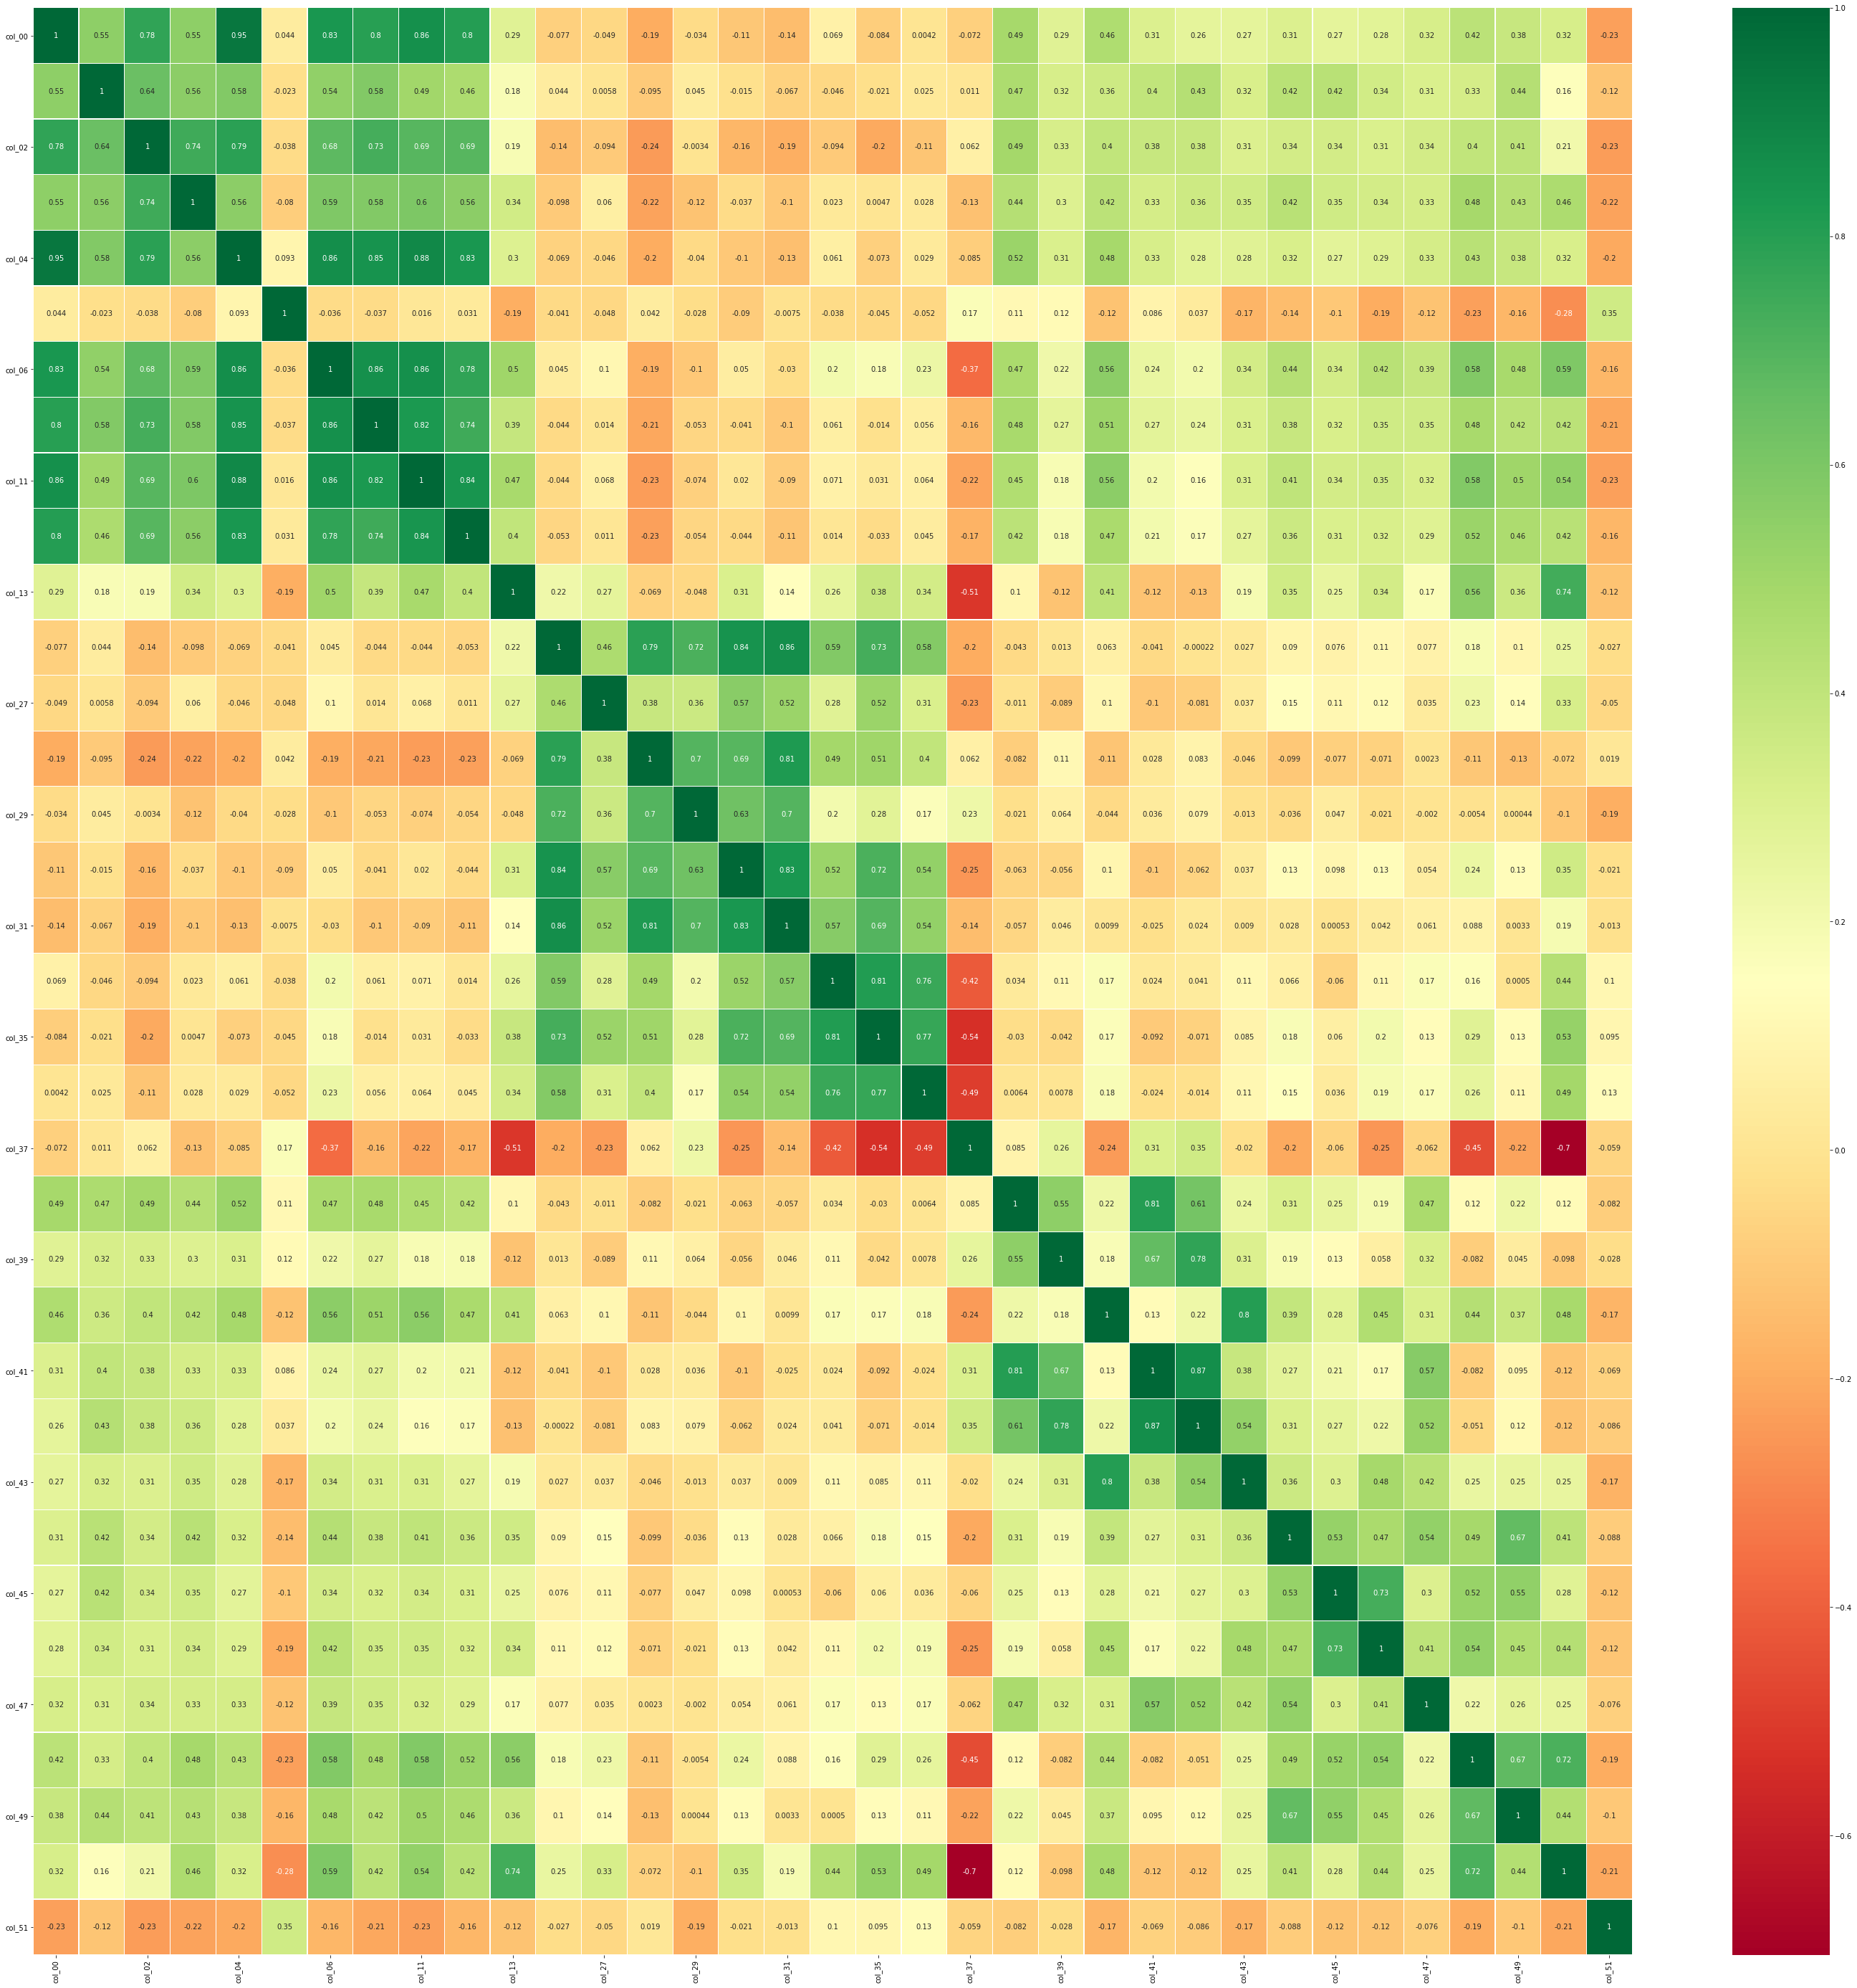

In [115]:
sns.heatmap(train_df.drop(columns='status').corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(50,50)
plt.show()

columns with >90% correlations

In [116]:
classi_corr = train_df.drop(columns='status').corr()
classi_corr.head()

,col_00,col_01,col_02,col_03,col_04,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
col_00,1.000000,0.547330,0.776865,0.553604,0.945674,0.044046,0.830186,0.795544,0.858052,0.803403,0.286286,-0.077388,-0.048739,-0.194974,-0.034290,-0.110637,-0.140275,0.068786,-0.083826,0.004241,-0.072272,0.485786,0.286684,0.460308,0.305649,0.261854,0.265946,0.305931,0.265098,0.280035,0.321243,0.418377,0.378027,0.322826,-0.228831
col_01,0.547330,1.000000,0.644918,0.560143,0.582505,-0.023152,0.544404,0.580787,0.494105,0.460937,0.180361,0.044324,0.005803,-0.095220,0.045220,-0.014530,-0.066534,-0.046360,-0.020898,0.025169,0.011382,0.465682,0.321415,0.360432,0.399875,0.434194,0.319776,0.422314,0.421765,0.342601,0.311634,0.330939,0.440470,0.157186,-0.116702
col_02,0.776865,0.644918,1.000000,0.740517,0.789578,-0.037998,0.678783,0.728958,0.693652,0.688563,0.187567,-0.141453,-0.093556,-0.240478,-0.003402,-0.162304,-0.190392,-0.094463,-0.202885,-0.112389,0.061678,0.487401,0.325319,0.398341,0.380558,0.375731,0.307464,0.338955,0.340871,0.313271,0.336189,0.396947,0.413780,0.212992,-0.233889
col_03,0.553604,0.560143,0.740517,1.000000,0.558723,-0.080226,0.591871,0.581817,0.600182,0.557274,0.342158,-0.098252,0.060461,-0.221796,-0.120909,-0.037157,-0.102341,0.023164,0.004747,0.028277,-0.126478,0.439358,0.295922,0.420560,0.332606,0.359836,0.349267,0.423915,0.352968,0.340225,0.329911,0.482569,0.432131,0.464439,-0.221089
col_04,0.945674,0.582505,0.789578,0.558723,1.000000,0.092514,0.862749,0.846467,0.883955,0.829245,0.296600,-0.069245,-0.046396,-0.197677,-0.040320,-0.102275,-0.132752,0.060692,-0.073290,0.029026,-0.084612,0.518664,0.310007,0.481454,0.327566,0.279899,0.284361,0.318420,0.270153,0.288799,0.332422,0.425350,0.377097,0.317557,-0.202887


In [117]:
columns = np.full((classi_corr.shape[0],), True, dtype=bool)

#pcc_cols = ['c1', 'c2', 'Co-effs']
#pcc_lst =[]

for i in range(classi_corr.shape[0]):
    for j in range(i+1, classi_corr.shape[0]):
        #pcc_lst.append([i, j, corr.iloc[i,j]])
        #pcc_df1 = pd.DataFrame(pcc_lst, columns = pcc_cols)
        if classi_corr.iloc[i,j] >= 0.9 or classi_corr.iloc[i,j] <= -0.9:
            if columns[j]:
                columns[j] = False

In [118]:
columns

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [120]:
selected_columns_classi = train_df.drop(columns = 'status').columns[columns]
selected_columns_classi.shape

(34,)

Selection of features for classifier

In [121]:
selected_columns_classi

Index(['col_00', 'col_01', 'col_02', 'col_03', 'col_05', 'col_06', 'col_07',
       'col_11', 'col_12', 'col_13', 'col_14', 'col_27', 'col_28', 'col_29',
       'col_30', 'col_31', 'col_34', 'col_35', 'col_36', 'col_37', 'col_38',
       'col_39', 'col_40', 'col_41', 'col_42', 'col_43', 'col_44', 'col_45',
       'col_46', 'col_47', 'col_48', 'col_49', 'col_50', 'col_51'],
      dtype='object')

In [122]:
classi_x = train_df[selected_columns_classi]
classi_x.shape

(13180, 34)

In [131]:
classi_x.head()

,col_00,col_01,col_02,col_03,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
12278,2.445718,49.08854,53.03819,46.310760,76.95741,13.34635,16.16753,51.539380,36.606610,1.784164,419.6276,455.6373,788.3645,701.0446,664.8148,761.4583,166.7023,324.9857,201.4553,82.36915,46.87500,34.89583,71.61458,32.81250,32.291660,40.36458,41.66667,53.53009,43.69213,40.509260,221.3542,76.67824,236.9792,198.7847
8372,2.459491,49.30555,53.12500,46.050346,77.45465,13.41146,16.21094,51.170970,37.031770,1.938014,420.3519,452.3379,779.9328,707.1124,677.7778,773.9583,167.9275,333.9023,197.9963,86.42762,53.64583,33.07291,70.83333,32.81250,32.552080,39.32291,40.79861,41.95602,45.13889,39.062500,192.9977,68.57639,228.5880,209.7801
771,2.460474,48.26389,53.16840,45.963539,71.67192,13.65017,16.07350,54.163438,36.562250,2.041516,420.4692,431.5300,782.2994,704.3047,653.7037,703.1250,173.8443,342.1648,209.9130,91.06766,49.21875,31.25000,61.71875,33.85416,32.552082,38.02083,42.53472,48.32176,40.79861,39.062500,165.5093,74.07407,219.9074,210.9375
2213,2.466377,47.26563,53.03819,45.963539,76.95788,13.59230,16.16753,51.716970,37.974952,1.909490,420.4633,458.8968,774.5200,681.5573,660.6481,755.2083,170.5929,333.1820,203.2823,113.24720,46.87500,33.07291,62.23958,31.77083,32.552080,38.80208,41.66667,46.29630,46.00694,39.641205,184.0278,69.73380,234.6644,192.9977
9011,2.465394,48.43750,53.12500,45.963539,73.23296,13.59230,16.16030,51.027780,37.192510,2.024022,420.7476,489.1272,763.6697,715.5057,620.3704,713.0208,170.9337,325.3874,203.4722,106.03250,47.91666,33.85416,75.26041,31.77083,33.854160,40.62500,47.74306,49.18982,44.56018,39.641200,203.9931,69.73380,241.3194,196.4699


In [126]:
classi_y = train_df['status']
classi_y.shape

(13180,)

Stratified K-fold CV + SMOTE + Standardization

- Stratified 5-fold cross validation
- SMOTE - oversampling minority class
- Standardisation of input features

In [129]:
K=5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [133]:
train_precision = []
train_recall = []
test_precision = []
test_recall = []

for train, test in skf.split(classi_x, classi_y):
    X_train = classi_x.iloc[train]
    Y_train = classi_y.iloc[train]
    X_test = classi_x.iloc[test]
    Y_test = classi_y.iloc[test]
    
    smote = SMOTE(random_state=42)
    x_train_res, y_train_res = smote.fit_sample(X_train, Y_train.ravel())
    x_train_res = pd.DataFrame(x_train_res, columns=X_train.columns)
    
    ### data scaling ###
    scaler = StandardScaler().fit(x_train_res.iloc[:, 0:35])  # StandardScaler();  MinMaxScaler()
    X_train_res_scaled = scaler.transform(x_train_res.iloc[:, 0:35])    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test.iloc[:, 0:35])
    
    X_train_num_scaled = pd.DataFrame(X_train_res_scaled, columns = X_train.iloc[:, 0:35].columns)
    X_test_num_scaled = pd.DataFrame(X_test_scaled, columns = X_test.iloc[:, 0:35].columns)
    
    ## model fitting
    model_xgb = xgb(objective = 'binary:logistic', random_state= 42)  #probability=True
    model_xgb.fit(X_train_num_scaled, y_train_res)

    ## predict on train and test data - check metrics
    y_pred_train = model_xgb.predict(X_train_num_scaled)
    y_pred_test = model_xgb.predict(X_test_num_scaled)
    
     #####    Compute confusion matrix     ####
    class_names = ['0','1'] 
    cnf_matrix = confusion_matrix(Y_test, y_pred_test)
    print(cnf_matrix)
    #print("4. Confusion matrix good")
    
    ## print metrics
    ##Classification report
    print(classification_report(Y_test, y_pred_test, target_names=class_names))
    
    print('Accuracy:', accuracy_score(Y_test, y_pred_test))
    print('F1 score:', f1_score(Y_test, y_pred_test))
    print('Recall:', recall_score(Y_test, y_pred_test))
    print('Precision:', precision_score(Y_test, y_pred_test))
    
    train_precision.append(precision_score(y_train_res, y_pred_train))
    train_recall.append(recall_score(y_train_res, y_pred_train))
    test_precision.append(precision_score(Y_test, y_pred_test))
    test_recall.append(recall_score(Y_test, y_pred_test))
    
    print('')

train_precision = pd.DataFrame(train_precision)
train_recall = pd.DataFrame(train_recall)
test_precision = pd.DataFrame(test_precision)
test_recall = pd.DataFrame(test_recall)
metrics = pd.concat([train_precision, test_precision, train_recall, test_recall], axis=1)
metrics.columns = ['train_precision', 'test_precision', 'train_recall', 'test_recall']

print(metrics)
print('avg test_precision: ' + str(metrics.test_precision.mean()))
print('avg test_recall: ' + str(metrics.test_recall.mean())) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[2447   10]
 [   0  179]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2457
           1       0.95      1.00      0.97       179

    accuracy                           1.00      2636
   macro avg       0.97      1.00      0.99      2636
weighted avg       1.00      1.00      1.00      2636

Accuracy: 0.996206373292868
F1 score: 0.9728260869565218
Recall: 1.0
Precision: 0.9470899470899471



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[2455    1]
 [   0  180]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2456
           1       0.99      1.00      1.00       180

    accuracy                           1.00      2636
   macro avg       1.00      1.00      1.00      2636
weighted avg       1.00      1.00      1.00      2636

Accuracy: 0.9996206373292867
F1 score: 0.9972299168975068
Recall: 1.0
Precision: 0.994475138121547



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[2451    5]
 [   0  180]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2456
           1       0.97      1.00      0.99       180

    accuracy                           1.00      2636
   macro avg       0.99      1.00      0.99      2636
weighted avg       1.00      1.00      1.00      2636

Accuracy: 0.9981031866464339
F1 score: 0.9863013698630138
Recall: 1.0
Precision: 0.972972972972973



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[2448    8]
 [   2  178]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2456
           1       0.96      0.99      0.97       180

    accuracy                           1.00      2636
   macro avg       0.98      0.99      0.99      2636
weighted avg       1.00      1.00      1.00      2636

Accuracy: 0.996206373292868
F1 score: 0.9726775956284154
Recall: 0.9888888888888889
Precision: 0.956989247311828



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[2453    3]
 [   0  180]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2456
           1       0.98      1.00      0.99       180

    accuracy                           1.00      2636
   macro avg       0.99      1.00      1.00      2636
weighted avg       1.00      1.00      1.00      2636

Accuracy: 0.9988619119878603
F1 score: 0.9917355371900827
Recall: 1.0
Precision: 0.9836065573770492

   train_precision  test_precision  train_recall  test_recall
0         0.999695        0.947090      1.000000     1.000000
1         0.999695        0.994475      1.000000     1.000000
2         0.999796        0.972973      1.000000     1.000000
3         0.999491        0.956989      0.999898     0.988889
4         0.999898        0.983607      1.000000     1.000000
avg train_precision: 0.9997150955709166
avg test_precision: 0.971026772574669
avg train_recall: 0.9999796437659032
avg test_recall: 0.9977777777777778


**Precision:**97.1%
<br> **Recall:**99.7%

##### Classifier Testing

In [134]:
test_classi = test_df[selected_columns_classi]

In [135]:
test_classi.shape

(4459, 34)

In [144]:
test_classi.head()

,col_00,col_01,col_02,col_03,col_05,col_06,col_07,col_11,col_12,col_13,col_14,col_27,col_28,col_29,col_30,col_31,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51
0,2.454178,48.524304,52.013889,44.626735,60.77929,13.71528,15.95052,39.55270,33.45079,2.287622,421.9709,467.84220,1151.3330,776.8110,248.6111,1083.3851,178.84330,354.9570,438.47750,88.28314,48.17708,40.62500,63.80208,36.97916,37.50000,43.48958,39.351850,39.641205,44.56018,46.87500,208.91200,57.002320,222.800900,227.1412
1,2.462049,47.005210,49.704859,44.574649,83.56953,14.09867,16.13136,49.82092,32.90169,0.081019,420.3102,473.71250,1044.9400,518.4980,689.3519,1020.3120,277.91870,553.0101,600.81790,50.95649,52.34375,31.51042,69.53125,32.81250,33.07291,41.92708,38.773150,36.747680,44.56018,39.35185,153.93520,50.636574,235.821800,173.9005
2,2.501007,46.050347,50.842012,44.835069,78.65768,14.33015,16.47135,47.28960,33.82491,7.401545,420.6254,508.54890,1052.2860,560.5950,656.0185,978.6458,363.55935,547.7377,876.34903,13.56911,46.61458,34.11458,87.50000,34.11458,35.15625,48.17708,49.768520,46.585650,51.21528,49.47917,199.94210,56.712960,222.415167,205.4398
3,2.471690,48.723957,51.293400,45.269095,59.62761,14.89439,16.42795,48.56744,37.50666,15.776120,420.0095,817.58317,674.4683,562.6851,748.1481,917.7083,212.31630,535.5938,809.79420,0.00000,53.12500,33.07291,62.76041,36.19791,32.81250,39.32291,36.747680,35.011574,39.64120,41.95602,191.55090,48.032410,209.008533,195.6019
4,2.460671,49.262154,51.684026,43.133679,81.84858,14.26505,16.13136,35.61920,15.37475,0.546472,420.5814,457.59910,1003.8810,722.4266,649.0740,853.6458,352.13900,513.6846,847.29870,26.77874,53.64583,41.66666,55.20833,35.15625,38.02083,42.70833,37.326389,38.194440,45.13889,43.98148,59.60648,48.032410,195.601900,188.3681


In [145]:
scaler = StandardScaler().fit(test_classi.iloc[:, 0:34])  #StandardScaler();  MinMaxScaler()
Xtest_scaled_classi = scaler.transform(test_classi.iloc[:, 0:34])
Xtest_num_scaled_classi = pd.DataFrame(Xtest_scaled_classi, columns = test_classi.iloc[:, 0:34].columns)

Y_pred_classi = model_xgb.predict(Xtest_num_scaled_classi)

In [147]:
Y_pred_classi

[array([0, 0, 0, ..., 0, 0, 0])]

In [149]:
np.unique(Y_pred_classi)

array([0, 1])

In [152]:
np.unique(Y_pred_classi, return_counts =  True)

(array([0, 1]), array([3742,  717]))

In [153]:
test_pred = pd.DataFrame(Y_pred_classi, columns = ['status'])

In [154]:
test_pred.head()

,status
0,0
1,0
2,0
3,0
4,1


In [155]:
test_df = pd.concat([test_classi, test_pred], axis=1)

Saving prediction results from regressor and classifier as csv file

In [156]:
test_df.to_csv("test_with_predictions.csv", index = False)

Save model as pickle file

In [163]:
# Save the trained model as a pickle string.
saved_model = pickle.dumps(model_xgb)

# Save the model as a pickle in a file
joblib.dump(model_xgb, 'classifier.pkl')

# Load the pickled model
xgb_from_pickle = pickle.loads(saved_model)
 
# Use the loaded pickled model to make predictions
xgb_from_pickle.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])